<font size="6"> **Прогноз температуры расплава** </font>

## Постановка задачи

Чтобы оптимизировать производственные расходы, металлургический комбинат решил построить модель, которая будет предсказывать температуру расплава в ковше, учитывая завершенные к этому моменту времени стадии технологического процесса


**Описание этапов обработки**

Сталь обрабатывают в металлическом ковше, расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами, далее добавляют примеси из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат, корректирующие химический состав и отбираются пробы.
Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем сплав перемешивают и снова проводят измерения. Такой цикл повторяется до тех пор, пока не будет достигнут нужный химический состав сплава и оптимальная температура плавки. Задача заключается в прогнозе температуры по завершении всех операций.

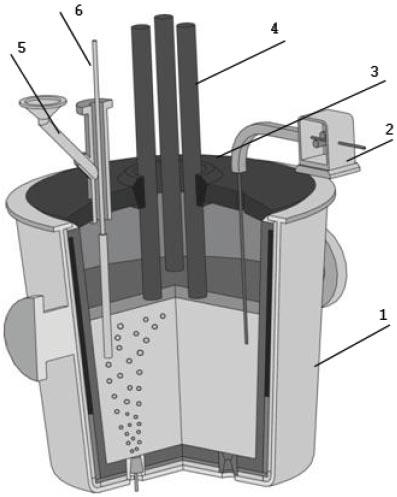

**Рисунок 1. Общая схема установки печь-ковш**

1. Сталеразливочный ковш;
2. Трайб-аппарат; 
3. Свод агрегата ковш-печь; 
4. Графитированные электроды; 
5. Воронка подачи сыпучих материалов;
6. Аварийная фурма.
- (без нумерации) снизу показано сопло подачи инертного газа 

**Критерии оценки и рекомендуемые модели**

В качестве критерия оценки качества модели по заданию необходимо использовать метрику `MAE`. Значение метрики должно быть не более `6.3`.

Необходимо рассмотреть следующие классы моделей:
- решающее дерево,
- бустинги,
- нейронные сети.

**Описание данных**

Данные хранятся в таблицах в базе данных PostgreSQL:
- `steel.data_arc` — данные об электродах,
- `steel.data_bulk` — данные о подаче сыпучих материалов (объём),
- `steel.data_bulk_time` — данные о подаче сыпучих материалов (время),
- `steel.data_gas` — данные о продувке сплава газом,
- `steel.data_temp` — результаты измерения температуры,
- `steel.data_wire` — данные о проволочных материалах (объём),
- `steel.data_wire_time` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В таблицах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

## Импорт библиотек, установка констант, подключение к БД

In [2]:
import numpy as np
import pandas as pd

from sqlalchemy import create_engine

import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt

from scipy.stats import jarque_bera
import phik

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.dummy import DummyRegressor

from catboost import CatBoostRegressor, Pool

import optuna

import tensorflow as tf
from tensorflow import keras
from keras import layers
import keras_tuner

import warnings
warnings.filterwarnings('ignore')

In [3]:
pd.set_option('display.max_columns', 20)
sns.set_theme(style='darkgrid')
FMDT = '%Y-%m-%d:%H:%M:%S'  # формат для данных datetime
FMT = '%H:%M:%S'            # формат для данных time
TDY = '2000-01-01'          # дата "сегодня" для перевода в datetime
TMW = '2000-01-02'          # дата "завтра" для перевода в datetime
RND_ST = 42
TRN_SZE = .7   # размер тренировочной выборки от общего объема данных
VAL_SZE = .15  # размер валидационной выборки от общего объема данных
TST_SZE = .15  # размер тестовой выборки от общего объема данных

In [4]:
db_config = {
    'user': 'user', 
    'pwd':  'password',
    'host': 'host',
    'port':  -,
    'db':   'db_name'
}

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'])

In [5]:
engine = create_engine(connection_string)

# Исследовательский анализ

## Первичное исследование таблиц

Выведем информацию для ответов на вопросы:
1. Все ли таблицы имеют набор данных;
2. Соответствует ли количество таблиц условию задачи;
3. Имеется ли общий ключ для связи таблиц.

Выведем информацию о таблицах схемы `steel`:
- название + полное название (table_alias)
- размер данных
- размер индексов в (индексы в PostgreSQL — специальные объекты, предназначенные в основном для ускорения доступа к данным)
- итоговый размер
- кол-во страниц
- оценка кол-ва строк в таблице
- кол-во столбцов в таблице

In [6]:
def showsql(query, return_df=True):
    '''Функция выводит на экран и/или сохраняет в переменную  результат sql запроса'''

    task = pd.read_sql_query(query, con=engine)
    if return_df:
        display(task)
        return task
    else:
        display(task)

In [7]:
query_stat = '''
WITH size_part AS(
SELECT table_name,
       table_alias,
       pg_size_pretty(table_size) AS table_size,
       pg_size_pretty(indexes_size) AS indexes_size,
       pg_size_pretty(total_size) AS total_size
FROM (
      SELECT table_name,
             table_alias,
             pg_table_size(table_alias) AS table_size,
             pg_indexes_size(table_alias) AS indexes_size,
             pg_total_relation_size(table_alias) AS total_size
      FROM (SELECT table_name,
                   table_schema,
                   concat(table_schema, '.', table_name)  AS table_alias
            FROM information_schema.tables
            WHERE table_schema IN ('steel')
            ) AS tables_info
        ) AS tables_stat
),

page_part AS (
SELECT relname,
       relpages,
       reltuples
FROM pg_class
),

columns_part AS(
SELECT table_name,
       COUNT(column_name) AS columns_qty
FROM information_schema.columns
WHERE table_schema = 'steel'
GROUP BY table_name)

SELECT s.table_name,
       s.table_alias,
       table_size,
       indexes_size,
       total_size,
       relpages AS pages_qty,
       reltuples AS rows_qty,
       columns_qty
FROM size_part AS s
JOIN page_part AS p ON s.table_name=p.relname
JOIN columns_part AS c ON c.table_name=s.table_name
'''
showsql(query_stat, False)

,table_name,table_alias,table_size,indexes_size,total_size,pages_qty,rows_qty,columns_qty
0,data_arc,steel.data_arc,1144 kB,0 bytes,1144 kB,139,14876.0,5
1,data_bulk,steel.data_bulk,224 kB,0 bytes,224 kB,24,3129.0,16
2,data_bulk_time,steel.data_bulk_time,248 kB,0 bytes,248 kB,28,3129.0,16
3,data_gas,steel.data_gas,176 kB,0 bytes,176 kB,18,3239.0,2
4,data_temp,steel.data_temp,824 kB,0 bytes,824 kB,99,15907.0,3
5,data_wire,steel.data_wire,200 kB,0 bytes,200 kB,21,3081.0,10
6,data_wire_time,steel.data_wire_time,192 kB,0 bytes,192 kB,21,3081.0,10


In [8]:
query_table_names = '''
SELECT table_name
FROM information_schema.tables
WHERE table_schema IN ('steel')
'''
table_names = showsql(query_table_names).values.flatten()

query_columns = '''
SELECT table_name,
       column_name,
       data_type 
FROM INFORMATION_SCHEMA.COLUMNS 
WHERE table_name = '''

for col in table_names:
    query_res = query_columns + "'" + col + "'"
    showsql(query_res, False)

,table_name
0,data_arc
1,data_bulk
2,data_bulk_time
3,data_gas
4,data_temp
5,data_wire
6,data_wire_time


,table_name,column_name,data_type
0,data_arc,key,integer
1,data_arc,BeginHeat,time without time zone
2,data_arc,EndHeat,time without time zone
3,data_arc,ActivePower,numeric
4,data_arc,ReactivePower,numeric


,table_name,column_name,data_type
0,data_bulk,key,integer
1,data_bulk,Bulk 1,numeric
2,data_bulk,Bulk 2,numeric
3,data_bulk,Bulk 3,numeric
4,data_bulk,Bulk 4,numeric
5,data_bulk,Bulk 5,numeric
6,data_bulk,Bulk 6,numeric
7,data_bulk,Bulk 7,numeric
8,data_bulk,Bulk 8,numeric
9,data_bulk,Bulk 9,numeric


,table_name,column_name,data_type
0,data_bulk_time,key,integer
1,data_bulk_time,Bulk 1,time without time zone
2,data_bulk_time,Bulk 2,time without time zone
3,data_bulk_time,Bulk 3,time without time zone
4,data_bulk_time,Bulk 4,time without time zone
5,data_bulk_time,Bulk 5,time without time zone
6,data_bulk_time,Bulk 6,time without time zone
7,data_bulk_time,Bulk 7,time without time zone
8,data_bulk_time,Bulk 8,time without time zone
9,data_bulk_time,Bulk 9,time without time zone


,table_name,column_name,data_type
0,data_gas,key,integer
1,data_gas,gas,numeric


,table_name,column_name,data_type
0,data_temp,key,integer
1,data_temp,MesaureTime,time without time zone
2,data_temp,Temperature,numeric


,table_name,column_name,data_type
0,data_wire,key,integer
1,data_wire,Wire 1,numeric
2,data_wire,Wire 2,numeric
3,data_wire,Wire 3,numeric
4,data_wire,Wire 4,numeric
5,data_wire,Wire 5,numeric
6,data_wire,Wire 6,numeric
7,data_wire,Wire 7,numeric
8,data_wire,Wire 8,numeric
9,data_wire,Wire 9,numeric


,table_name,column_name,data_type
0,data_wire_time,key,integer
1,data_wire_time,Wire 1,time without time zone
2,data_wire_time,Wire 2,time without time zone
3,data_wire_time,Wire 3,time without time zone
4,data_wire_time,Wire 4,time without time zone
5,data_wire_time,Wire 5,time without time zone
6,data_wire_time,Wire 6,time without time zone
7,data_wire_time,Wire 7,time without time zone
8,data_wire_time,Wire 8,time without time zone
9,data_wire_time,Wire 9,time without time zone


### Вывод

1. Все таблицы содержат данные
2. Кол-во таблиц соответствует условию задачи, **НО** кол-во колонок с данными по объему проволочных материалов в таблицах `data_wire` и `data_wire_time` составляет 9, а не 15, как указано в условии.
3. У всех таблиц есть общий ключ - поле `key`, тип данных `integer`.

## Пересечение таблиц по ключам

In [9]:
query_unique_key_by_table = '''
WITH 
ark AS (SELECT DISTINCT(key) AS arc_key
        FROM steel.data_arc),
bulk AS (SELECT DISTINCT(key) AS bulk_key
         FROM steel.data_bulk),
bulk_time AS (SELECT DISTINCT(key) AS bulk_time_key
              FROM steel.data_bulk_time),
gas AS (SELECT DISTINCT(key) AS gas_key
        FROM steel.data_gas),
temp AS (SELECT DISTINCT(key) AS temp_key
         FROM steel.data_temp),
wire AS (SELECT DISTINCT(key) AS wire_key
         FROM steel.data_wire),
wire_time AS (SELECT DISTINCT(key) AS wire_time_key
              FROM steel.data_wire_time)

SELECT COUNT(arc_key) AS arc_unique,
       COUNT(bulk_key) AS bulk_unique,
       COUNT(bulk_time_key) AS bulk_time_unique,
       COUNT(gas_key) AS gas_unique,
       COUNT(temp_key) AS temp_unique,
       COUNT(wire_key) AS wire_unique,
       COUNT(wire_time_key) AS wire_time_unique
FROM ark AS arc
FULL OUTER JOIN bulk AS bulk ON arc.arc_key=bulk.bulk_key
FULL OUTER JOIN bulk_time AS bulk_time ON bulk_time.bulk_time_key=arc.arc_key
FULL OUTER JOIN gas AS gas ON gas.gas_key=arc.arc_key
FULL OUTER JOIN temp AS temp ON temp.temp_key=arc.arc_key
FULL OUTER JOIN wire AS wire ON wire.wire_key=arc.arc_key
FULL OUTER JOIN wire_time AS wire_time ON wire_time.wire_time_key=arc.arc_key
'''

query_unique_key_cross = '''
WITH 
ark AS (SELECT DISTINCT(key) AS arc_key
        FROM steel.data_arc),
bulk AS (SELECT DISTINCT(key) AS bulk_key
         FROM steel.data_bulk),
bulk_time AS (SELECT DISTINCT(key) AS bulk_time_key
              FROM steel.data_bulk_time),
gas AS (SELECT DISTINCT(key) AS gas_key
        FROM steel.data_gas),
temp AS (SELECT DISTINCT(key) AS temp_key
         FROM steel.data_temp),
wire AS (SELECT DISTINCT(key) AS wire_key
         FROM steel.data_wire),
wire_time AS (SELECT DISTINCT(key) AS wire_time_key
              FROM steel.data_wire_time)

SELECT COUNT(arc_key) AS arc_cross,
       COUNT(bulk_key) AS bulk_cross,
       COUNT(bulk_time_key) AS bulk_time_cross,
       COUNT(gas_key) AS gas_cross,
       COUNT(temp_key) AS temp_cross,
       COUNT(wire_key) AS wire_cross,
       COUNT(wire_time_key) AS wire_time_cross
FROM ark AS arc
INNER JOIN bulk AS bulk ON arc.arc_key=bulk.bulk_key
INNER JOIN bulk_time AS bulk_time ON bulk_time.bulk_time_key=arc.arc_key
INNER JOIN gas AS gas ON gas.gas_key=arc.arc_key
INNER JOIN temp AS temp ON temp.temp_key=arc.arc_key
INNER JOIN wire AS wire ON wire.wire_key=arc.arc_key
INNER JOIN wire_time AS wire_time ON wire_time.wire_time_key=arc.arc_key
'''


showsql(query_unique_key_by_table, False)
showsql(query_unique_key_cross, False)

,arc_unique,bulk_unique,bulk_time_unique,gas_unique,temp_unique,wire_unique,wire_time_unique
0,3214,3129,3129,3239,3216,3081,3081


,arc_cross,bulk_cross,bulk_time_cross,gas_cross,temp_cross,wire_cross,wire_time_cross
0,3022,3022,3022,3022,3022,3022,3022


### Вывод

В каждой из таблиц разное кол-во уникальных ключей (см. суффикс `_unique`). Пересечений по ключам (см. суффикс `_cross`) во всех таблицах найдено `3022`. Все расчеты и аналитику далее целесообразно проводить **ТОЛЬКО** для записей, для которых есть ключ во всех таблицах.

## Обязательные вопросы

Следующие вопросы обозначены отдельными пунктами, необходимо найти для каждого значения `key`

### Сколько времени прошло между первым и последним замером температуры

Решение проблемы с названиями столбцов одновременно заглавными и прописными буквами [тут](https://stackoverflow.com/questions/14351743/change-table-column-names-to-upper-case-in-postgres)

In [10]:
query_temp_measurment_time_first_to_last = '''
WITH 
key_filter AS (
  WITH 
  ark AS (SELECT DISTINCT(key) AS arc_key
          FROM steel.data_arc),
  bulk AS (SELECT DISTINCT(key) AS bulk_key
           FROM steel.data_bulk),
  bulk_time AS (SELECT DISTINCT(key) AS bulk_time_key
                FROM steel.data_bulk_time),
  gas AS (SELECT DISTINCT(key) AS gas_key
        FROM steel.data_gas),
  temp AS (SELECT DISTINCT(key) AS temp_key
           FROM steel.data_temp),
  wire AS (SELECT DISTINCT(key) AS wire_key
           FROM steel.data_wire),
  wire_time AS (SELECT DISTINCT(key) AS wire_time_key
                FROM steel.data_wire_time)
  SELECT arc_key
  FROM ark AS arc
  INNER JOIN bulk AS bulk ON arc.arc_key=bulk.bulk_key
  INNER JOIN bulk_time AS bulk_time ON bulk_time.bulk_time_key=arc.arc_key
  INNER JOIN gas AS gas ON gas.gas_key=arc.arc_key
  INNER JOIN temp AS temp ON temp.temp_key=arc.arc_key
  INNER JOIN wire AS wire ON wire.wire_key=arc.arc_key
  INNER JOIN wire_time AS wire_time ON wire_time.wire_time_key=arc.arc_key
),

am_stat AS (SELECT DISTINCT(key),
                   ((MAX("MesaureTime") OVER (PARTITION BY key))
                   - (MIN("MesaureTime") OVER (PARTITION BY key)) ) AS gap,
                   (MIN("MesaureTime") OVER (PARTITION BY key) - TIME'00:00:00') AS zero_to_first_am,
                   (TIME'12:00:00' - MAX("MesaureTime") OVER (PARTITION BY key)) AS last_am_to_noon,
                   COUNT("MesaureTime") OVER (PARTITION BY key) AS measurments_qty
            FROM steel.data_temp
            WHERE EXTRACT(HOUR FROM "MesaureTime") <= 12
),

pm_stat AS (SELECT DISTINCT(key),
                   ((MAX("MesaureTime") OVER (PARTITION BY key))
                   - (MIN("MesaureTime") OVER (PARTITION BY key)) ) AS gap,
                   (TIME'23:59:60' - MAX("MesaureTime") OVER (PARTITION BY key)) AS last_pm_to_midnight,
                   (MIN("MesaureTime") OVER (PARTITION BY key) - TIME'12:00:00') AS noon_to_first_pm,
                   COUNT("MesaureTime") OVER (PARTITION BY key) AS measurments_qty
            FROM steel.data_temp
            WHERE EXTRACT(HOUR FROM "MesaureTime") > 12
),

join_table AS (SELECT am_stat.key AS am_key,
                      pm_stat.key AS pm_key,
                      am_stat.gap AS am_gap,
                      pm_stat.gap AS pm_gap,
                      am_stat.zero_to_first_am,
                      am_stat.last_am_to_noon,
                      pm_stat.last_pm_to_midnight,
                      pm_stat.noon_to_first_pm,
                      am_stat.measurments_qty AS am_count,
                      pm_stat.measurments_qty AS pm_count
               FROM am_stat AS am_stat
               FULL OUTER JOIN pm_stat AS pm_stat ON am_stat.key=pm_stat.key
),

core_table AS (SELECT CASE
                          WHEN am_key IS NULL THEN pm_key
                          WHEN pm_key IS NULL THEN am_key
                          ELSE am_key
                      END AS key,
                      CASE
                          WHEN am_gap IS NULL THEN pm_gap
                          WHEN pm_gap IS NULL THEN am_gap
                          ELSE am_gap + pm_gap
                               + LEAST(zero_to_first_am, last_am_to_noon)
                               + LEAST(last_pm_to_midnight, noon_to_first_pm)
                      END AS from_first_to_last,
                      CASE
                          WHEN am_count IS NULL THEN pm_count
                          WHEN pm_count IS NULL THEN am_count
                          ELSE am_count + pm_count
                      END AS measurement_qty
                FROM join_table
)

SELECT key,
       from_first_to_last,
       EXTRACT(HOUR FROM from_first_to_last)*3600
       + EXTRACT(MINUTE FROM from_first_to_last)*60
       + EXTRACT(SECONDS FROM from_first_to_last) AS from_first_to_last_sec,
       measurement_qty
FROM key_filter AS kf
LEFT JOIN core_table AS ct ON kf.arc_key=ct.key
ORDER BY from_first_to_last_sec
'''
temp_measurment_time_first_to_last_df = showsql(query_temp_measurment_time_first_to_last)

,key,from_first_to_last,from_first_to_last_sec,measurement_qty
0,3214,0 days 00:03:17,197.0,2
1,2486,0 days 00:03:54,234.0,2
2,977,0 days 00:03:56,236.0,2
3,600,0 days 00:04:18,258.0,3
4,3212,0 days 00:04:20,260.0,2
...,...,...,...,...
3017,638,0 days 03:33:09,12789.0,8
3018,641,0 days 04:37:49,16669.0,6
3019,1958,0 days 05:15:48,18948.0,9
3020,2108,0 days 05:48:43,20923.0,15


Для данной таблицы следует сделать оговорку: если измерение проводилось, **НО** значение температуры не было зафиксировано (NULL), то такое измерние *считается за измерение*. Далее при подготовке данных мы удалим такие случаи, но для данного запроса - формально измерение проводилось, есть время измерения, но значение температуры - не зафиксировано.

### Суммарное время нагрева электродами, т.е. $\sum$ значений по всем промежуткам между запусками нагрева электродами

In [11]:
query_arc_heating_total_time = '''
WITH 
key_filter AS (
  WITH 
  ark AS (SELECT DISTINCT(key) AS arc_key
          FROM steel.data_arc),
  bulk AS (SELECT DISTINCT(key) AS bulk_key
           FROM steel.data_bulk),
  bulk_time AS (SELECT DISTINCT(key) AS bulk_time_key
                FROM steel.data_bulk_time),
  gas AS (SELECT DISTINCT(key) AS gas_key
        FROM steel.data_gas),
  temp AS (SELECT DISTINCT(key) AS temp_key
           FROM steel.data_temp),
  wire AS (SELECT DISTINCT(key) AS wire_key
           FROM steel.data_wire),
  wire_time AS (SELECT DISTINCT(key) AS wire_time_key
                FROM steel.data_wire_time)
  SELECT arc_key
  FROM ark AS arc
  INNER JOIN bulk AS bulk ON arc.arc_key=bulk.bulk_key
  INNER JOIN bulk_time AS bulk_time ON bulk_time.bulk_time_key=arc.arc_key
  INNER JOIN gas AS gas ON gas.gas_key=arc.arc_key
  INNER JOIN temp AS temp ON temp.temp_key=arc.arc_key
  INNER JOIN wire AS wire ON wire.wire_key=arc.arc_key
  INNER JOIN wire_time AS wire_time ON wire_time.wire_time_key=arc.arc_key
                ),

core_table AS (
SELECT key,
       SUM(duration)::time without time zone AS total_heat_duration
FROM (SELECT key,
            "BeginHeat" AS start,
            "EndHeat" AS finish,
           ("EndHeat" - "BeginHeat" + TIME'23:59:60') AS duration
      FROM steel.data_arc) AS pre_core_table
GROUP BY key)

SELECT kf.arc_key AS key,
       ct.total_heat_duration,
       EXTRACT(HOUR FROM ct.total_heat_duration)*3600
       + EXTRACT(MINUTE FROM ct.total_heat_duration)*60
       + EXTRACT(SECONDS FROM ct.total_heat_duration) AS total_heat_duration_sec
FROM key_filter AS kf
LEFT JOIN core_table AS ct ON kf.arc_key=ct.key
ORDER BY total_heat_duration DESC
'''
arc_heating_total_time_df = showsql(query_arc_heating_total_time)

,key,total_heat_duration,total_heat_duration_sec
0,1689,01:09:49,4189.0
1,46,00:48:39,2919.0
2,1880,00:45:55,2755.0
3,2108,00:45:39,2739.0
4,322,00:44:18,2658.0
...,...,...,...
3017,1988,00:01:47,107.0
3018,112,00:01:35,95.0
3019,1766,00:01:04,64.0
3020,943,00:01:01,61.0


### Количество запусков нагрева электродами

In [12]:
query_heating_cycles = '''
WITH 
key_filter AS (
  WITH 
  ark AS (SELECT DISTINCT(key) AS arc_key
          FROM steel.data_arc),
  bulk AS (SELECT DISTINCT(key) AS bulk_key
           FROM steel.data_bulk),
  bulk_time AS (SELECT DISTINCT(key) AS bulk_time_key
                FROM steel.data_bulk_time),
  gas AS (SELECT DISTINCT(key) AS gas_key
        FROM steel.data_gas),
  temp AS (SELECT DISTINCT(key) AS temp_key
           FROM steel.data_temp),
  wire AS (SELECT DISTINCT(key) AS wire_key
           FROM steel.data_wire),
  wire_time AS (SELECT DISTINCT(key) AS wire_time_key
                FROM steel.data_wire_time)
  SELECT arc_key
  FROM ark AS arc
  INNER JOIN bulk AS bulk ON arc.arc_key=bulk.bulk_key
  INNER JOIN bulk_time AS bulk_time ON bulk_time.bulk_time_key=arc.arc_key
  INNER JOIN gas AS gas ON gas.gas_key=arc.arc_key
  INNER JOIN temp AS temp ON temp.temp_key=arc.arc_key
  INNER JOIN wire AS wire ON wire.wire_key=arc.arc_key
  INNER JOIN wire_time AS wire_time ON wire_time.wire_time_key=arc.arc_key
                ),

core_table AS (
  SELECT key,
         COUNT(key) AS heating_cycles
  FROM steel.data_arc
  GROUP BY key
              )

SELECT kf.arc_key AS key,
       ct.heating_cycles
FROM key_filter AS kf
LEFT JOIN core_table AS ct ON kf.arc_key=ct.key
ORDER BY heating_cycles DESC
'''
heating_cycles_df = showsql(query_heating_cycles)

,key,heating_cycles
0,2108,16
1,1689,15
2,1513,15
3,2567,14
4,46,13
...,...,...
3017,943,1
3018,112,1
3019,49,1
3020,732,1


### Среднее соотношение потребления активной и реактивной мощности

In [13]:
query_avg_power_ratio = '''
WITH 
key_filter AS (
  WITH 
  ark AS (SELECT DISTINCT(key) AS arc_key
          FROM steel.data_arc),
  bulk AS (SELECT DISTINCT(key) AS bulk_key
           FROM steel.data_bulk),
  bulk_time AS (SELECT DISTINCT(key) AS bulk_time_key
                FROM steel.data_bulk_time),
  gas AS (SELECT DISTINCT(key) AS gas_key
        FROM steel.data_gas),
  temp AS (SELECT DISTINCT(key) AS temp_key
           FROM steel.data_temp),
  wire AS (SELECT DISTINCT(key) AS wire_key
           FROM steel.data_wire),
  wire_time AS (SELECT DISTINCT(key) AS wire_time_key
                FROM steel.data_wire_time)
  SELECT arc_key
  FROM ark AS arc
  INNER JOIN bulk AS bulk ON arc.arc_key=bulk.bulk_key
  INNER JOIN bulk_time AS bulk_time ON bulk_time.bulk_time_key=arc.arc_key
  INNER JOIN gas AS gas ON gas.gas_key=arc.arc_key
  INNER JOIN temp AS temp ON temp.temp_key=arc.arc_key
  INNER JOIN wire AS wire ON wire.wire_key=arc.arc_key
  INNER JOIN wire_time AS wire_time ON wire_time.wire_time_key=arc.arc_key
                ),

core_table AS(
  SELECT key,
         AVG(power_ratio) AS avg_power_ratio
  FROM (SELECT key,
               "ActivePower"/ "ReactivePower" AS power_ratio
        FROM steel.data_arc) AS power_ratio_subtable
  GROUP BY key)
  
SELECT kf.arc_key AS key,
       ct.avg_power_ratio
FROM key_filter AS kf
LEFT JOIN core_table AS ct ON kf.arc_key=ct.key
ORDER BY avg_power_ratio DESC
'''
avg_power_ratio_df = showsql(query_avg_power_ratio)

,key,avg_power_ratio
0,36,1.782164
1,1020,1.730417
2,2918,1.727129
3,577,1.717679
4,2920,1.716893
...,...,...
3017,2780,0.754200
3018,2343,0.715287
3019,552,0.706339
3020,2142,0.687735


### По всем столбцам вычислите стат. показатели: средние, мин. и макс., медиану и величины квартилей 25% и 75%

In [14]:
united_df = (
    temp_measurment_time_first_to_last_df.merge(
        arc_heating_total_time_df, how='inner', on='key'
    )
    .merge(heating_cycles_df, how='inner', on='key')
    .merge(avg_power_ratio_df, how='inner', on='key')[
        [
            'key',
            'measurement_qty',
            'from_first_to_last_sec',
            'total_heat_duration_sec',
            'heating_cycles',
            'avg_power_ratio',
        ]
    ]
)

Значения выведем, используя метод `describe()`, при этом медиана - это 50% квартиль

In [15]:
united_df.describe()

,key,measurement_qty,from_first_to_last_sec,total_heat_duration_sec,heating_cycles,avg_power_ratio
count,3022.000000,3022.000000,3022.000000,3022.000000,3022.000000,3022.000000
mean,1623.313038,4.979484,1884.397088,801.683322,4.698875,1.357385
std,931.884924,1.783251,1265.446866,331.577570,1.604155,0.133702
min,1.000000,2.000000,197.000000,57.000000,1.000000,0.676106
25%,821.250000,4.000000,1211.000000,576.500000,4.000000,1.291916
50%,1618.500000,5.000000,1628.000000,776.000000,5.000000,1.370512
75%,2429.750000,6.000000,2273.750000,987.000000,6.000000,1.438994
max,3241.000000,16.000000,23537.000000,4189.000000,16.000000,1.782164


## Загрузка данных

Загружать данные будем сразу отфильтровав записи, для которых есть ключи во всех таблицах.

### Таблица `data_temp`

In [16]:
query_temp_load = '''
WITH 
key_filter AS (
  WITH 
  ark AS (SELECT DISTINCT(key) AS arc_key
          FROM steel.data_arc),
  bulk AS (SELECT DISTINCT(key) AS bulk_key
           FROM steel.data_bulk),
  bulk_time AS (SELECT DISTINCT(key) AS bulk_time_key
                FROM steel.data_bulk_time),
  gas AS (SELECT DISTINCT(key) AS gas_key
        FROM steel.data_gas),
  temp AS (SELECT DISTINCT(key) AS temp_key
           FROM steel.data_temp),
  wire AS (SELECT DISTINCT(key) AS wire_key
           FROM steel.data_wire),
  wire_time AS (SELECT DISTINCT(key) AS wire_time_key
                FROM steel.data_wire_time)
  SELECT arc_key
  FROM ark AS arc
  INNER JOIN bulk AS bulk ON arc.arc_key=bulk.bulk_key
  INNER JOIN bulk_time AS bulk_time ON bulk_time.bulk_time_key=arc.arc_key
  INNER JOIN gas AS gas ON gas.gas_key=arc.arc_key
  INNER JOIN temp AS temp ON temp.temp_key=arc.arc_key
  INNER JOIN wire AS wire ON wire.wire_key=arc.arc_key
  INNER JOIN wire_time AS wire_time ON wire_time.wire_time_key=arc.arc_key
                ),

core_table AS (SELECT key,
                     "Temperature" AS temp,
                     "MesaureTime" AS time
               FROM steel.data_temp
               )
SELECT key,
       temp,
       time
FROM key_filter AS kf
LEFT JOIN core_table AS ct ON kf.arc_key=ct.key
'''
temp_raw = showsql(query_temp_load)

,key,temp,time
0,1,1571.0,11:16:18
1,1,1604.0,11:25:53
2,1,1618.0,11:29:11
3,1,1601.0,11:30:01
4,1,1613.0,11:30:39
...,...,...,...
15043,3241,1586.0,04:03:30
15044,3241,NaN,04:16:12
15045,3241,NaN,04:22:39
15046,3241,NaN,04:33:42


In [17]:
temp_raw.isna().sum()

key        0
temp    2746
time       0
dtype: int64

Пропуски в `temp` - это либо ошибки ввода/вывода либо какие-то другие факторы. В итоге - значение не зафиксировано.
Удалим строки, где есть пропуски в столбце `temp`, т.к. отсутствует целевой признак.

In [18]:
temp_raw = temp_raw.dropna(subset=['temp'])

### Таблица `data_arc`

При загрузке добавим рассчеты для каждой записи:
- продолжительность каждого цикла нагрева в сек., `duration_orgn`

Реактивная мощность характеризует потери в индуктивной нагрузке (трансформаторе), питающем электрорды. Поскольку на разных стадиях обработки стали трансформатор работает в разных режимах (напряжение, сила тока) [ссылка](https://stroi-archive.ru/proizvodstvo-stali-v-elektropechah/10636-temperaturnyy-i-elektricheskiy-rezhim-plavki-stali.html), то реактивная мощность зависит от режима. Однако, реактивная мощность **НЕ ВНОСИТ** вклад в полезную работу (нагрев), а относится к техническим потерям в электросетях согласно Приказу Минпромэнерго РФ № 267 от 04.10.2005 [ссылка](https://studfile.net/preview/4614527/page:16/)

Поэтому данные по реактивной мощности - **не** загружаем.

In [19]:
query_arc_load = '''
WITH 
key_filter AS (
  WITH 
  ark AS (SELECT DISTINCT(key) AS arc_key
          FROM steel.data_arc),
  bulk AS (SELECT DISTINCT(key) AS bulk_key
           FROM steel.data_bulk),
  bulk_time AS (SELECT DISTINCT(key) AS bulk_time_key
                FROM steel.data_bulk_time),
  gas AS (SELECT DISTINCT(key) AS gas_key
        FROM steel.data_gas),
  temp AS (SELECT DISTINCT(key) AS temp_key
           FROM steel.data_temp),
  wire AS (SELECT DISTINCT(key) AS wire_key
           FROM steel.data_wire),
  wire_time AS (SELECT DISTINCT(key) AS wire_time_key
                FROM steel.data_wire_time)
  SELECT arc_key
  FROM ark AS arc
  INNER JOIN bulk AS bulk ON arc.arc_key=bulk.bulk_key
  INNER JOIN bulk_time AS bulk_time ON bulk_time.bulk_time_key=arc.arc_key
  INNER JOIN gas AS gas ON gas.gas_key=arc.arc_key
  INNER JOIN temp AS temp ON temp.temp_key=arc.arc_key
  INNER JOIN wire AS wire ON wire.wire_key=arc.arc_key
  INNER JOIN wire_time AS wire_time ON wire_time.wire_time_key=arc.arc_key
                ),

core_table AS (
SELECT key,
       "BeginHeat" AS begin_heat,
       "EndHeat" AS end_heat,
       ("EndHeat" - "BeginHeat" + TIME'23:59:60') AS duration,
       "ActivePower" AS active_power
FROM steel.data_arc)

SELECT key,
       active_power,
       begin_heat,
       end_heat,
       EXTRACT(HOUR FROM duration)*3600
       + EXTRACT(MINUTE FROM duration)*60
       + EXTRACT(SECONDS FROM duration) AS duration_orgn
FROM key_filter AS kf
LEFT JOIN core_table AS ct ON kf.arc_key=ct.key
'''
arc_raw = showsql(query_arc_load)

,key,active_power,begin_heat,end_heat,duration_orgn
0,1,0.976059,11:02:14,11:06:02,228.0
1,1,0.805607,11:07:28,11:10:33,185.0
2,1,0.744363,11:11:44,11:14:36,172.0
3,1,1.659363,11:18:14,11:24:19,365.0
4,1,0.692755,11:26:09,11:28:37,148.0
...,...,...,...,...,...
14195,3241,0.533670,03:58:58,04:01:35,157.0
14196,3241,0.676604,04:05:04,04:08:04,180.0
14197,3241,0.733899,04:16:41,04:19:45,184.0
14198,3241,0.306580,04:34:47,04:36:08,81.0


Проверим визуально правильность конвертации продолжительности нагрева `duration_orgn` для случаев перехода через `00:00:00`

In [20]:
arc_raw.sort_values('end_heat').head(10)

,key,active_power,begin_heat,end_heat,duration_orgn
1074,257,0.268811,23:58:57,00:00:07,70.0
6908,1572,0.476221,23:57:55,00:00:13,138.0
3279,745,0.403792,23:58:27,00:00:14,107.0
7523,1702,0.430305,23:58:32,00:00:14,102.0
12298,2798,0.724873,23:57:30,00:00:32,182.0
9102,2063,0.566324,23:58:36,00:00:41,125.0
5270,1204,0.200258,00:00:05,00:00:49,44.0
11589,2638,0.534497,23:58:18,00:00:51,153.0
6165,1404,1.217748,23:56:33,00:01:05,272.0
6551,1486,1.135938,23:56:24,00:01:21,297.0


### Таблица `data_bulk_time`

In [21]:
query_bulk_time_load = '''
WITH 
key_filter AS (
  WITH 
  ark AS (SELECT DISTINCT(key) AS arc_key
          FROM steel.data_arc),
  bulk AS (SELECT DISTINCT(key) AS bulk_key
           FROM steel.data_bulk),
  bulk_time AS (SELECT DISTINCT(key) AS bulk_time_key
                FROM steel.data_bulk_time),
  gas AS (SELECT DISTINCT(key) AS gas_key
        FROM steel.data_gas),
  temp AS (SELECT DISTINCT(key) AS temp_key
           FROM steel.data_temp),
  wire AS (SELECT DISTINCT(key) AS wire_key
           FROM steel.data_wire),
  wire_time AS (SELECT DISTINCT(key) AS wire_time_key
                FROM steel.data_wire_time)
  SELECT arc_key
  FROM ark AS arc
  INNER JOIN bulk AS bulk ON arc.arc_key=bulk.bulk_key
  INNER JOIN bulk_time AS bulk_time ON bulk_time.bulk_time_key=arc.arc_key
  INNER JOIN gas AS gas ON gas.gas_key=arc.arc_key
  INNER JOIN temp AS temp ON temp.temp_key=arc.arc_key
  INNER JOIN wire AS wire ON wire.wire_key=arc.arc_key
  INNER JOIN wire_time AS wire_time ON wire_time.wire_time_key=arc.arc_key
                ),

core_table AS (SELECT *
               FROM steel.data_bulk_time
               )
SELECT key,
       "Bulk 1" AS bulk_1,
       "Bulk 2" AS bulk_2,
       "Bulk 3" AS bulk_3,
       "Bulk 4" AS bulk_4,
       "Bulk 5" AS bulk_5,
       "Bulk 6" AS bulk_6,
       "Bulk 7" AS bulk_7,
       "Bulk 8" AS bulk_8,
       "Bulk 9" AS bulk_9,
       "Bulk 10" AS bulk_10,
       "Bulk 11" AS bulk_11,
       "Bulk 12" AS bulk_12,
       "Bulk 13" AS bulk_13,
       "Bulk 14" AS bulk_14,
       "Bulk 15" AS bulk_15
FROM key_filter AS kf
LEFT JOIN core_table AS ct ON kf.arc_key=ct.key
'''
bulk_time_raw = showsql(query_bulk_time_load)

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,None,None,None,11:21:30,None,None,None,None,None,None,None,11:03:52,None,11:03:52,11:03:52
1,2,None,None,None,11:46:38,None,None,None,None,None,None,None,11:40:20,None,11:40:20,11:40:20
2,3,None,None,None,12:31:06,None,None,None,None,None,None,None,12:09:40,None,12:09:40,12:09:40
3,4,None,None,None,12:48:43,None,None,None,None,None,None,None,12:41:24,None,12:41:24,12:41:24
4,5,None,None,None,13:18:50,None,None,None,None,None,None,None,13:12:56,None,13:12:56,13:12:56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3017,3237,None,None,22:51:28,None,None,None,None,None,None,None,None,22:46:52,None,22:46:52,22:46:52
3018,3238,None,None,23:39:11,None,None,None,None,None,None,None,None,23:33:09,None,23:33:09,23:33:09
3019,3239,None,None,None,None,None,01:51:58,None,None,None,None,None,01:39:41,None,01:33:25,01:33:25
3020,3240,None,None,None,None,None,03:12:40,None,None,None,None,None,None,None,02:41:27,02:41:27


### Таблица `data_bulk`

In [22]:
query_bulk_load = '''
WITH 
key_filter AS (
  WITH 
  ark AS (SELECT DISTINCT(key) AS arc_key
          FROM steel.data_arc),
  bulk AS (SELECT DISTINCT(key) AS bulk_key
           FROM steel.data_bulk),
  bulk_time AS (SELECT DISTINCT(key) AS bulk_time_key
                FROM steel.data_bulk_time),
  gas AS (SELECT DISTINCT(key) AS gas_key
        FROM steel.data_gas),
  temp AS (SELECT DISTINCT(key) AS temp_key
           FROM steel.data_temp),
  wire AS (SELECT DISTINCT(key) AS wire_key
           FROM steel.data_wire),
  wire_time AS (SELECT DISTINCT(key) AS wire_time_key
                FROM steel.data_wire_time)
  SELECT arc_key
  FROM ark AS arc
  INNER JOIN bulk AS bulk ON arc.arc_key=bulk.bulk_key
  INNER JOIN bulk_time AS bulk_time ON bulk_time.bulk_time_key=arc.arc_key
  INNER JOIN gas AS gas ON gas.gas_key=arc.arc_key
  INNER JOIN temp AS temp ON temp.temp_key=arc.arc_key
  INNER JOIN wire AS wire ON wire.wire_key=arc.arc_key
  INNER JOIN wire_time AS wire_time ON wire_time.wire_time_key=arc.arc_key
                ),

core_table AS (SELECT *
               FROM steel.data_bulk
               )
SELECT key,
       "Bulk 1" AS bulk_1,
       "Bulk 2" AS bulk_2,
       "Bulk 3" AS bulk_3,
       "Bulk 4" AS bulk_4,
       "Bulk 5" AS bulk_5,
       "Bulk 6" AS bulk_6,
       "Bulk 7" AS bulk_7,
       "Bulk 8" AS bulk_8,
       "Bulk 9" AS bulk_9,
       "Bulk 10" AS bulk_10,
       "Bulk 11" AS bulk_11,
       "Bulk 12" AS bulk_12,
       "Bulk 13" AS bulk_13,
       "Bulk 14" AS bulk_14,
       "Bulk 15" AS bulk_15
FROM key_filter AS kf
LEFT JOIN core_table AS ct ON kf.arc_key=ct.key
'''
bulk_raw = showsql(query_bulk_load)

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3017,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3018,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3019,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3020,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0


### Таблица `data_wire_time`

In [23]:
query_wire_time_load = '''
WITH 
key_filter AS (
  WITH 
  ark AS (SELECT DISTINCT(key) AS arc_key
          FROM steel.data_arc),
  bulk AS (SELECT DISTINCT(key) AS bulk_key
           FROM steel.data_bulk),
  bulk_time AS (SELECT DISTINCT(key) AS bulk_time_key
                FROM steel.data_bulk_time),
  gas AS (SELECT DISTINCT(key) AS gas_key
        FROM steel.data_gas),
  temp AS (SELECT DISTINCT(key) AS temp_key
           FROM steel.data_temp),
  wire AS (SELECT DISTINCT(key) AS wire_key
           FROM steel.data_wire),
  wire_time AS (SELECT DISTINCT(key) AS wire_time_key
                FROM steel.data_wire_time)
  SELECT arc_key
  FROM ark AS arc
  INNER JOIN bulk AS bulk ON arc.arc_key=bulk.bulk_key
  INNER JOIN bulk_time AS bulk_time ON bulk_time.bulk_time_key=arc.arc_key
  INNER JOIN gas AS gas ON gas.gas_key=arc.arc_key
  INNER JOIN temp AS temp ON temp.temp_key=arc.arc_key
  INNER JOIN wire AS wire ON wire.wire_key=arc.arc_key
  INNER JOIN wire_time AS wire_time ON wire_time.wire_time_key=arc.arc_key
                ),

core_table AS (SELECT *
               FROM steel.data_wire_time
               )
SELECT key,
       "Wire 1" AS wire_1,
       "Wire 2" AS wire_2,
       "Wire 3" AS wire_3,
       "Wire 4" AS wire_4,
       "Wire 5" AS wire_5,
       "Wire 6" AS wire_6,
       "Wire 7" AS wire_7,
       "Wire 8" AS wire_8,
       "Wire 9" AS wire_9
FROM key_filter AS kf
LEFT JOIN core_table AS ct ON kf.arc_key=ct.key
'''
wire_time_raw = showsql(query_wire_time_load)

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,11:11:41,None,None,None,None,None,None,None,None
1,2,11:46:10,None,None,None,None,None,None,None,None
2,3,12:13:47,None,None,None,None,None,None,None,None
3,4,12:48:05,None,None,None,None,None,None,None,None
4,5,13:18:15,13:32:06,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...
3017,3237,22:50:20,None,None,None,None,None,None,None,None
3018,3238,23:38:24,None,None,None,None,None,None,None,None
3019,3239,01:50:43,None,None,None,None,None,None,None,None
3020,3240,03:12:02,None,None,None,None,None,None,None,None


### Таблица `data_wire`

In [24]:
query_wire_load = '''
WITH 
key_filter AS (
  WITH 
  ark AS (SELECT DISTINCT(key) AS arc_key
          FROM steel.data_arc),
  bulk AS (SELECT DISTINCT(key) AS bulk_key
           FROM steel.data_bulk),
  bulk_time AS (SELECT DISTINCT(key) AS bulk_time_key
                FROM steel.data_bulk_time),
  gas AS (SELECT DISTINCT(key) AS gas_key
        FROM steel.data_gas),
  temp AS (SELECT DISTINCT(key) AS temp_key
           FROM steel.data_temp),
  wire AS (SELECT DISTINCT(key) AS wire_key
           FROM steel.data_wire),
  wire_time AS (SELECT DISTINCT(key) AS wire_time_key
                FROM steel.data_wire_time)
  SELECT arc_key
  FROM ark AS arc
  INNER JOIN bulk AS bulk ON arc.arc_key=bulk.bulk_key
  INNER JOIN bulk_time AS bulk_time ON bulk_time.bulk_time_key=arc.arc_key
  INNER JOIN gas AS gas ON gas.gas_key=arc.arc_key
  INNER JOIN temp AS temp ON temp.temp_key=arc.arc_key
  INNER JOIN wire AS wire ON wire.wire_key=arc.arc_key
  INNER JOIN wire_time AS wire_time ON wire_time.wire_time_key=arc.arc_key
                ),

core_table AS (SELECT *
               FROM steel.data_wire
               )
SELECT key,
       "Wire 1" AS wire_1,
       "Wire 2" AS wire_2,
       "Wire 3" AS wire_3,
       "Wire 4" AS wire_4,
       "Wire 5" AS wire_5,
       "Wire 6" AS wire_6,
       "Wire 7" AS wire_7,
       "Wire 8" AS wire_8,
       "Wire 9" AS wire_9
FROM key_filter AS kf
LEFT JOIN core_table AS ct ON kf.arc_key=ct.key
'''
wire_raw = showsql(query_wire_load)

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3017,3237,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3018,3238,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3019,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3020,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Таблица `data_gas`

In [25]:
query_gas_load = '''
WITH 
key_filter AS (
  WITH 
  ark AS (SELECT DISTINCT(key) AS arc_key
          FROM steel.data_arc),
  bulk AS (SELECT DISTINCT(key) AS bulk_key
           FROM steel.data_bulk),
  bulk_time AS (SELECT DISTINCT(key) AS bulk_time_key
                FROM steel.data_bulk_time),
  gas AS (SELECT DISTINCT(key) AS gas_key
        FROM steel.data_gas),
  temp AS (SELECT DISTINCT(key) AS temp_key
           FROM steel.data_temp),
  wire AS (SELECT DISTINCT(key) AS wire_key
           FROM steel.data_wire),
  wire_time AS (SELECT DISTINCT(key) AS wire_time_key
                FROM steel.data_wire_time)
  SELECT arc_key
  FROM ark AS arc
  INNER JOIN bulk AS bulk ON arc.arc_key=bulk.bulk_key
  INNER JOIN bulk_time AS bulk_time ON bulk_time.bulk_time_key=arc.arc_key
  INNER JOIN gas AS gas ON gas.gas_key=arc.arc_key
  INNER JOIN temp AS temp ON temp.temp_key=arc.arc_key
  INNER JOIN wire AS wire ON wire.wire_key=arc.arc_key
  INNER JOIN wire_time AS wire_time ON wire_time.wire_time_key=arc.arc_key
                ),

core_table AS (SELECT key,
                      gas
               FROM steel.data_gas
               )
SELECT key,
       gas
FROM key_filter AS kf
LEFT JOIN core_table AS ct ON kf.arc_key=ct.key
'''
gas_raw = showsql(query_gas_load)

,key,gas
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
...,...,...
3017,3237,5.543905
3018,3238,6.745669
3019,3239,16.023518
3020,3240,11.863103


### Вывод

Все данные таблиц, для значений `key`, которые присутствуют во всех таблицах, загружены. Сохранены в переменные:
- `steel.data_temp` в `temp_raw` ( + удалены пропуски в значениях температуры)
- `stee.data_arc` в `arc_raw`
- `steel.data_bulk_time` в `bulk_time_raw`
- `steel.data_bulk` в `bulk_raw`
- `steel.data_wire_time` в `wire_time_raw`
- `steel.data_wire` в `wire_raw`
- `steel.data_gas` в `gas_raw`

## Исследование отметок времени для каждой партии `key`

Для того, чтоб иметь возможность сравнивать события, нам необходимо перейти от форомата `time` в данных времени к формату `datetime`. Все данные по отметкам времени для каждого `key` необходимо собрать вместе. Это даст полную картину по времени событий, относящихся к каждому `key`. После перехода к формату `datetime` и определения время последнего измерения температуры, мы сможем исключить все события, произошедшие после времени последнего измерения.

Из каждой таблицы, содержащей данные о времени, создадим выборки в формате `key, time`

In [26]:
arc_time = pd.concat(
    [
        arc_raw[['key', 'begin_heat']].rename(columns={'begin_heat': 'time'}),
        arc_raw[['key', 'end_heat']].rename(columns={'end_heat': 'time'}),
    ],
    axis=0,
)
arc_time

,key,time
0,1,11:02:14
1,1,11:07:28
2,1,11:11:44
3,1,11:18:14
4,1,11:26:09
...,...,...
14195,3241,04:01:35
14196,3241,04:08:04
14197,3241,04:19:45
14198,3241,04:36:08


In [27]:
temp_time = temp_raw[['key', 'time']]
temp_time

,key,time
0,1,11:16:18
1,1,11:25:53
2,1,11:29:11
3,1,11:30:01
4,1,11:30:39
...,...,...
15019,3237,22:44:04
15024,3238,23:30:31
15027,3239,01:31:47
15035,3240,02:39:01


In [28]:
bulk_time_melt = (
    pd.melt(
        frame=bulk_time_raw,
        id_vars=['key'],
        var_name='bulk_type',
        value_name='time'
    )
    .sort_values(['key', 'bulk_type'])
    .dropna(subset=['time'], axis=0)
)

bulk_time = bulk_time_melt[['key', 'time']]
bulk_time

,key,time
33242,1,11:03:52
39286,1,11:03:52
42308,1,11:03:52
9066,1,11:21:30
33243,2,11:40:20
...,...,...
42306,3240,02:41:27
45328,3240,02:41:27
18130,3240,03:12:40
42307,3241,04:05:34


In [29]:
wire_time_melt = (
    pd.melt(
        frame=wire_time_raw,
        id_vars=['key'],
        var_name='wire_type',
        value_name='time'
    )
    .sort_values(['key', 'wire_type'])
    .dropna(subset=['time'], axis=0)
)
wire_time = wire_time_melt[['key', 'time']]
wire_time

,key,time
0,1,11:11:41
1,2,11:46:10
2,3,12:13:47
3,4,12:48:05
4,5,13:18:15
...,...,...
3017,3237,22:50:20
3018,3238,23:38:24
3019,3239,01:50:43
3020,3240,03:12:02


In [30]:
(len(arc_time)
 +len(temp_time)
 +len(bulk_time)
 +len(wire_time)
)

55896

После конкатенации `arc_time`, `temp_time`, `bulk_time` и `wire_time` должна получиться таблица длинной `55896` строк

In [31]:
key_time = pd.concat([arc_time,
                      temp_time,
                      bulk_time,
                      wire_time], axis=0)
key_time

,key,time
0,1,11:02:14
1,1,11:07:28
2,1,11:11:44
3,1,11:18:14
4,1,11:26:09
...,...,...
3017,3237,22:50:20
3018,3238,23:38:24
3019,3239,01:50:43
3020,3240,03:12:02


Создадим столбец `max_diff`, который равен разности `max` и `min` значения в столбце `time` для каждого `key`.

Номера `key`, где присутствует переход через 00:00:00 можно найти, отфильтровав значения в столбце `max_diff`. Если эта разница более 12 часов, то есть переход через 00:00:00

In [32]:
key_time_diff = key_time.groupby('key').agg({'time': ['min', 'max']})
key_time_diff.columns = [
    "_".join(col).rstrip("_") for col in key_time_diff.columns.values
]
key_time_diff['max_diff'] = key_time_diff.apply(
    lambda t: dt.datetime.strptime(str(t['time_max']), FMT)
    - dt.datetime.strptime(str(t['time_min']), FMT),
    axis=1,
)
key_time_diff[key_time_diff['max_diff'] > dt.timedelta(hours=12)].sort_values(
    'max_diff'
)

,time_min,time_max,max_diff
key,,,
641,00:46:34,20:45:39,0 days 19:59:05
1958,01:51:42,22:52:30,0 days 21:00:48
44,00:32:02,22:50:26,0 days 22:18:24
1263,00:19:00,23:45:12,0 days 23:26:12
1516,00:19:38,23:52:24,0 days 23:32:46
...,...,...,...
1264,00:00:07,23:58:58,0 days 23:58:51
1026,00:00:11,23:59:04,0 days 23:58:53
1292,00:00:45,23:59:43,0 days 23:58:58


Найдено `68` таких случаев. Сохраним значения `key`, для которых время событий переходит через отметку 00:00:00 в переменной `zero_time_keys`

In [33]:
zero_time_keys = key_time_diff[key_time_diff['max_diff'] > dt.timedelta(hours=12)].index

### Вывод

Найдено `68` значений `key`, для которых время событий переходит отметку `00:00:00`. Значения сохранены в переменной `zero_time_keys`

## Исследование данных

### Данные температуры `temp_raw`

...после удаления пропусков в `temp` в разделе `3.4.1` еще раз проверим кол-во уникальных ключей

In [34]:
temp_raw['key'].nunique()

3022

Посмотрим на распределение значений температуры

In [35]:
def box_hist_distribution(df, column, color='lightblue'):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    sns.boxplot(y=column, data=df, ax=ax[0], color=color)
    sns.histplot(df, x=column, edgecolor=".3", ax=ax[1], color=color)
    sns.despine(offset=10, trim=True)
    fig.suptitle(
        'Распределение значений в столбце "' + column + '"', y=1.0, fontsize=16
    )

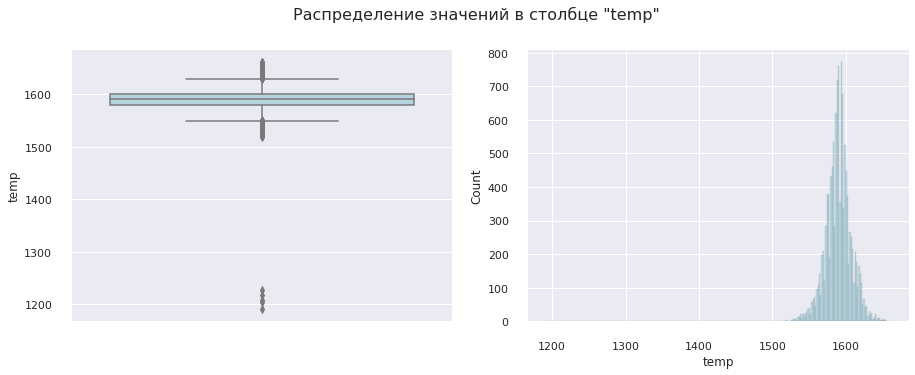

In [36]:
box_hist_distribution(temp_raw, 'temp')

Присутствуют выбросы "слева". Видно, что выбросы "левее" отметки `1500`. Посмотрим сколько значений находится "левее" этой границы.

In [37]:
temp_raw.query('temp < 1500')#.shape[0]

,key,temp,time
4102,867,1191.0,14:21:00
5647,1214,1208.0,05:32:00
7548,1619,1218.0,11:03:54
9612,2052,1227.0,14:51:40
11906,2561,1204.0,07:34:15


Всего 5 значений.

Во-первых: все `key` разные, т.е. для каждого `key` всего одно результативное измерение.

Во-вторых: по [ссылке](https://stroi-archive.ru/proizvodstvo-stali-v-elektropechah/10636-temperaturnyy-i-elektricheskiy-rezhim-plavki-stali.html) можно посмотреть наиболее характерные температуры при электродуговой плавке. Как видно температурный режим плавки должен быть в районе 1500+ градусов. Значения в районе 1200 явно какие-то аномальные.
Исключим эти `5` значений, выведем заново распределение

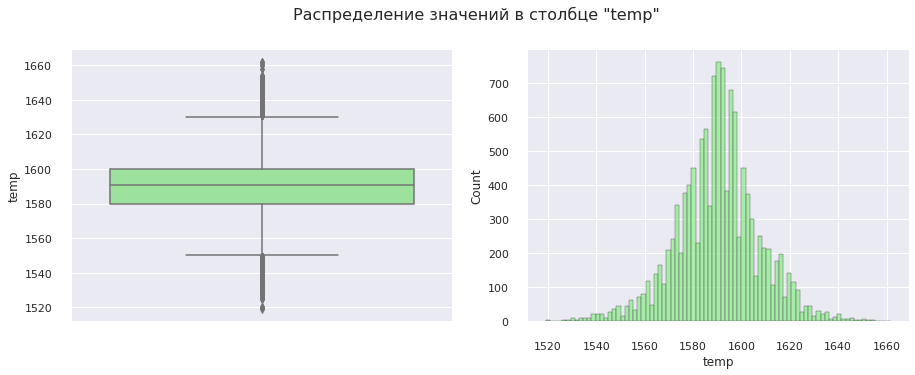

In [38]:
temp_raw = temp_raw[temp_raw['temp'] > 1500]
box_hist_distribution(temp_raw, 'temp', 'lightgreen')

Проверим кол-во уникальных `key` после удаления

In [39]:
temp_raw['key'].nunique()

3021

Визуально распределение очень напоминает нормальное. Для проверки гипотезы о нормальном распределении проведем тест Харки-Бера

In [40]:
print(jarque_bera(temp_raw['temp']))

Jarque_beraResult(statistic=524.1309460899581, pvalue=0.0)


Нулевая гипотеза о том, что данные распределены нормально - отвергается т.к. `p-value = 0`

Нужно перевести все данные времени (столбец `time`) из формата `time` в формат `datetime`. Это позволит найти последний зафиксированный результат измерения температуры для конкретной партии (`key`). Это и есть **целевой признак**.

Установим значение в формате `datetime` в столбце `temp_measure_time_dt` по правилу: если значение часа менее `12` и `key` в списке `zero_time_keys`, то присваиваем дату `TMW (завтра)`. В остальных случаях присваиваем дату `TDY (сегодня)`

In [41]:
temp_raw['temp_measure_time_dt'] = temp_raw.apply(
    lambda x: dt.datetime.strptime(
        ':'.join([ TMW, x['time'].strftime(FMT) ]), FMDT
    ) 
    if (x['time'].hour < 12) & (x['key'] in zero_time_keys)  
    else dt.datetime.strptime(
        ':'.join([ TDY, x['time'].strftime(FMT) ]), FMDT
    ),
    axis=1
)

Выведем фрагмент таблицы `temp_raw` после обработки

In [42]:
temp_raw.query('key in @zero_time_keys')[3:17]

,key,temp,time,temp_measure_time_dt
91,18,1592.0,23:54:33,2000-01-01 23:54:33
92,18,1604.0,23:59:48,2000-01-01 23:59:48
93,18,1598.0,00:04:12,2000-01-02 00:04:12
94,18,1595.0,00:08:29,2000-01-02 00:08:29
225,44,1600.0,22:13:44,2000-01-01 22:13:44
226,44,1608.0,22:32:26,2000-01-01 22:32:26
227,44,1619.0,22:39:37,2000-01-01 22:39:37
228,44,1600.0,22:43:49,2000-01-01 22:43:49
229,44,1605.0,22:44:29,2000-01-01 22:44:29
230,44,1601.0,22:46:49,2000-01-01 22:46:49


Сформируем таблицу `temp_stat` где соберем данные для каждого `key` по времени первой и последней **зафиксированной температуры** и по кол-ву результативных замеров температуры и по времени в минутах между первым и последним замером.

**P.S.** В "сырых данных" присутствовали строки, где время измерения температуры есть, а самого значения температуры не зафиксировано.

In [43]:
temp_stat = (
    temp_raw.groupby('key', as_index=False)
    .agg({'temp_measure_time_dt': ['min', 'max', 'count']})
)
temp_stat.columns = ['_'.join(col).rstrip('_') for col in temp_stat.columns.values]
temp_stat['delta_first_to_last_measure'] = temp_stat['temp_measure_time_dt_max']-temp_stat['temp_measure_time_dt_min']
temp_stat['minutes_first_to_last_measure'] = temp_stat.apply(
    lambda t: t['delta_first_to_last_measure'].total_seconds()/60, axis=1
)

temp_stat

,key,temp_measure_time_dt_min,temp_measure_time_dt_max,temp_measure_time_dt_count,delta_first_to_last_measure,minutes_first_to_last_measure
0,1,2000-01-01 11:16:18,2000-01-01 11:30:39,5,0 days 00:14:21,14.350000
1,2,2000-01-01 11:37:27,2000-01-01 11:59:12,6,0 days 00:21:45,21.750000
2,3,2000-01-01 12:13:17,2000-01-01 12:34:57,5,0 days 00:21:40,21.666667
3,4,2000-01-01 12:52:57,2000-01-01 12:59:25,3,0 days 00:06:28,6.466667
4,5,2000-01-01 13:23:19,2000-01-01 13:36:01,2,0 days 00:12:42,12.700000
...,...,...,...,...,...,...
3016,3237,2000-01-01 22:44:04,2000-01-01 22:44:04,1,0 days 00:00:00,0.000000
3017,3238,2000-01-01 23:30:31,2000-01-01 23:30:31,1,0 days 00:00:00,0.000000
3018,3239,2000-01-01 01:31:47,2000-01-01 01:31:47,1,0 days 00:00:00,0.000000
3019,3240,2000-01-01 02:39:01,2000-01-01 02:39:01,1,0 days 00:00:00,0.000000


Значение первой измеренной температуры планируем забрать в признаки. Значение последней измереной температуры - это **целевой признак**. Случаи, где замер температуры только один - не подходят. Нужно как минимум **два измерения** . Значения `key` у которых только один результативный замер температуры сохраним в переменной `temp_keys_del` и исключим эти `key` из `temp_stat`.

In [44]:
temp_keys_del = temp_stat.query('temp_measure_time_dt_count == 1')['key'].values
temp_stat = temp_stat.query('key not in @temp_keys_del')
len(temp_keys_del)

692

Данные для признаков и целевого признака сохраним в переменной `temp_df`

In [45]:
temp_fch = (
    temp_stat[['key','temp_measure_time_dt_min', 'minutes_first_to_last_measure']]
    .rename( columns={'temp_measure_time_dt_min':'temp_measure_time_dt'})
    .merge(temp_raw, how='left', on=['key', 'temp_measure_time_dt'])[
        ['key', 'temp_measure_time_dt', 'temp', 'minutes_first_to_last_measure']
    ].set_index('key')
)

temp_trgt = (
    temp_stat[['key','temp_measure_time_dt_max']]
    .rename( columns={'temp_measure_time_dt_max':'temp_measure_time_dt'})
    .merge(temp_raw, how='left', on=['key', 'temp_measure_time_dt'])[
        ['key', 'temp_measure_time_dt', 'temp']
    ].set_index('key')
)

temp_df = (
    temp_fch.join(temp_trgt, lsuffix='_fch', rsuffix='_trgt')
    .rename(columns={'temp_measure_time_dt_fch':'temp_start_time_dt',
                     'temp_measure_time_dt_trgt':'temp_measure_time_dt'})
)

In [46]:
temp_df

,temp_start_time_dt,temp_fch,minutes_first_to_last_measure,temp_measure_time_dt,temp_trgt
key,,,,,
1,2000-01-01 11:16:18,1571.0,14.350000,2000-01-01 11:30:39,1613.0
2,2000-01-01 11:37:27,1581.0,21.750000,2000-01-01 11:59:12,1602.0
3,2000-01-01 12:13:17,1596.0,21.666667,2000-01-01 12:34:57,1599.0
4,2000-01-01 12:52:57,1601.0,6.466667,2000-01-01 12:59:25,1625.0
5,2000-01-01 13:23:19,1576.0,12.700000,2000-01-01 13:36:01,1602.0
...,...,...,...,...,...
2495,2000-01-01 00:35:45,1570.0,18.950000,2000-01-01 00:54:42,1591.0
2496,2000-01-01 01:02:54,1554.0,26.966667,2000-01-01 01:29:52,1591.0
2497,2000-01-01 01:41:53,1571.0,11.950000,2000-01-01 01:53:50,1589.0


In [47]:
temp_df.describe()

,temp_fch,minutes_first_to_last_measure,temp_trgt
count,2329.000000,2329.000000,2329.000000
mean,1587.386003,31.638171,1593.365393
std,23.619841,22.034243,11.200915
min,1519.000000,3.900000,1541.000000
25%,1571.000000,20.250000,1587.000000
50%,1587.000000,27.233333,1593.000000
75%,1603.000000,38.166667,1598.000000
max,1660.000000,392.283333,1653.000000


Выведем статистику и распределение значений последнего замера температуры (**целевой признак**)

,count,mean,std,min,25%,50%,75%,max
temp_trgt,2329.0,1593.365393,11.200915,1541.0,1587.0,1593.0,1598.0,1653.0


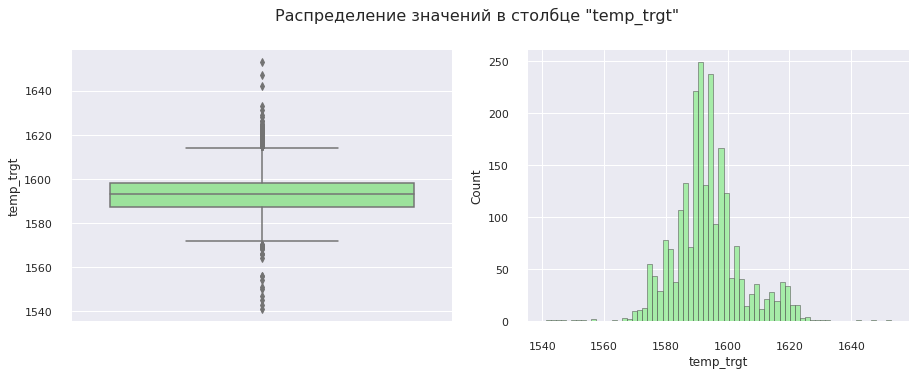

In [48]:
display(temp_df[['temp_trgt']].describe().T)
box_hist_distribution(temp_df, 'temp_trgt', 'lightgreen')

Выведем статистику и распределение значений первого замера температуры

,count,mean,std,min,25%,50%,75%,max
temp_fch,2329.0,1587.386003,23.619841,1519.0,1571.0,1587.0,1603.0,1660.0


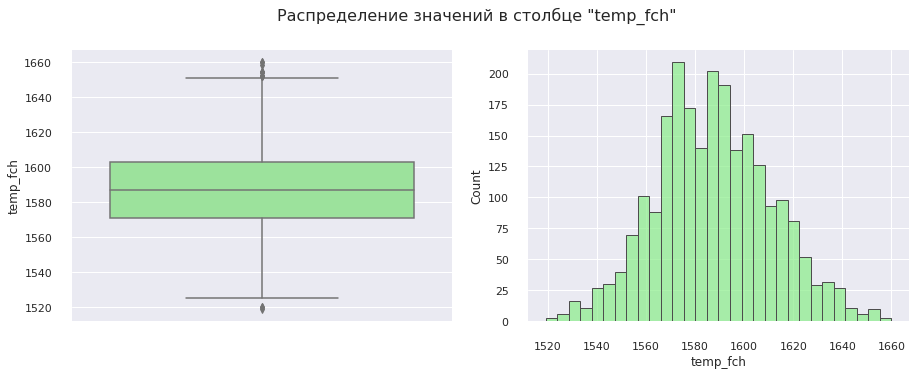

In [55]:
display(temp_df[['temp_fch']].describe().T)
box_hist_distribution(temp_df, 'temp_fch', 'lightgreen')

Значения в `temp_fch` не содержат выбросов.

Выведем распределение для данных продолжительности в минутах между первым и последним измерениями темпереатуры

,count,mean,std,min,25%,50%,75%,max
minutes_first_to_last_measure,2329.0,31.638171,22.034243,3.9,20.25,27.233333,38.166667,392.283333


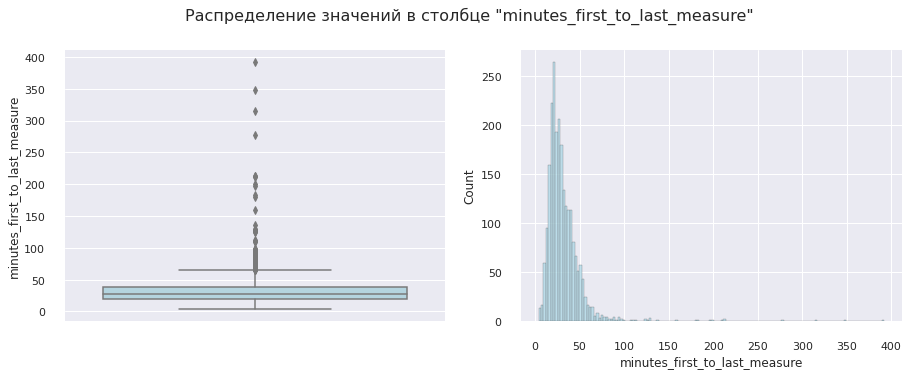

In [56]:
display(temp_df[['minutes_first_to_last_measure']].describe().T)
box_hist_distribution(temp_df, 'minutes_first_to_last_measure')

Попробуем понять есть ли какие-то особенности у партий `key` для которых время м/у первым и последним измерением температуры `minutes_first_to_last_measure` велико (больше значения 99 квартиля).

Возможно кол-во циклов нагрева и общее время нагрева как-то объясняет длительность всего техпроцесса и соответственно большое значение м/у первым и последним замером?...

In [62]:
first_to_last_high = temp_df['minutes_first_to_last_measure'].quantile(0.99)
first_to_last_measure_outliers_keys = temp_df.query('minutes_first_to_last_measure > @first_to_last_high').index

heating_cycles_df.set_index('key').loc[first_to_last_measure_outliers_keys, :].join(
    temp_df.loc[first_to_last_measure_outliers_keys, :]).join(
    arc_heating_total_time_df.set_index('key').loc[first_to_last_measure_outliers_keys, 'total_heat_duration_sec' ])[
    ['minutes_first_to_last_measure',
     'heating_cycles',
     'total_heat_duration_sec',
     'temp_start_time_dt',
     'temp_measure_time_dt']
].sort_values('minutes_first_to_last_measure')

,minutes_first_to_last_measure,heating_cycles,total_heat_duration_sec,temp_start_time_dt,temp_measure_time_dt
key,,,,,
115,97.966667,6,725.0,2000-01-01 11:01:24,2000-01-01 12:39:22
2110,98.650000,5,547.0,2000-01-01 17:42:36,2000-01-01 19:21:15
274,108.633333,10,1910.0,2000-01-01 16:22:51,2000-01-01 18:11:29
2109,110.966667,7,814.0,2000-01-01 15:04:51,2000-01-01 16:55:49
322,112.083333,13,2658.0,2000-01-01 09:10:07,2000-01-01 11:02:12
639,125.100000,6,1439.0,2000-01-01 20:01:10,2000-01-01 22:06:16
2001,125.166667,7,2065.0,2000-01-01 20:33:50,2000-01-01 22:39:00
2151,127.433333,8,1639.0,2000-01-01 02:32:36,2000-01-01 04:40:02
959,128.116667,7,1502.0,2000-01-01 19:04:18,2000-01-01 21:12:25


Явной связи нет. Оставляем эти значения т.к. нет ясного понимания являются ли они аномальными. Значения `key` сохранены в переменной `first_to_last_measure_outliers_keys`

**P.S.**

Для проверки корректности вычисления времени между первым и последним **результативными измерениями температуры**, можно объединить `time_df`, добавив столбец `time_diff`, где рассчитать время между первым и последним замерами, и датафрейм `temp_measurment_time_first_to_last_df`, который мы получили SQL запросом в разделе `3.3.1` и где эта разность также была рассчитана в столбце `from_first_to_last`.

In [63]:
(temp_df[['temp_start_time_dt', 'temp_measure_time_dt']]
 .assign(time_diff = lambda t: t['temp_measure_time_dt'] - t['temp_start_time_dt'])
 .join(temp_measurment_time_first_to_last_df.set_index('key')['from_first_to_last'], how='left')
 .sort_values('temp_measure_time_dt')
)

,temp_start_time_dt,temp_measure_time_dt,time_diff,from_first_to_last
key,,,,
1792,2000-01-01 00:05:01,2000-01-01 00:21:58,0 days 00:16:57,0 days 00:16:57
2494,2000-01-01 00:12:55,2000-01-01 00:23:21,0 days 00:10:26,0 days 00:10:26
1326,2000-01-01 00:06:12,2000-01-01 00:25:35,0 days 00:19:23,0 days 00:19:23
2115,2000-01-01 00:07:46,2000-01-01 00:26:10,0 days 00:18:24,0 days 00:18:24
768,2000-01-01 00:04:13,2000-01-01 00:26:31,0 days 00:22:18,0 days 00:22:18
...,...,...,...,...
1516,2000-01-01 23:40:56,2000-01-02 00:43:58,0 days 01:03:02,0 days 01:03:02
641,2000-01-01 20:35:10,2000-01-02 01:12:59,0 days 04:37:49,0 days 04:37:49
44,2000-01-01 22:13:44,2000-01-02 01:13:17,0 days 02:59:33,0 days 02:59:33


In [64]:
temp_df.describe().T

,count,mean,std,min,25%,50%,75%,max
temp_fch,2329.0,1587.386003,23.619841,1519.0,1571.00,1587.000000,1603.000000,1660.000000
minutes_first_to_last_measure,2329.0,31.638171,22.034243,3.9,20.25,27.233333,38.166667,392.283333
temp_trgt,2329.0,1593.365393,11.200915,1541.0,1587.00,1593.000000,1598.000000,1653.000000


#### Вывод

Сформирована таблица `temp_df` с временем измерения и значениями первой и последней измеренной температурой и с продолжительностью в минутах между первым и последним замерами для `2329` значений `key`.

Для целевой переменой `temp_trgt` значения распределены в диапазоне от `1541` до `1653`, с медианой `1593` и средним `1593`. 

Для первого замера  температуры `temp_fch` значения распределены в диапазоне от `1519` до `1660`, с медианой `1587` и средним `1587`

Для времени в минутах между замерами `minutes_first_to_last_measure` значения распределены от `3.9` до `392`, с медианой `27.2` и средним `31.6`.

Время первого измерения температуры является границей, после которой мы будем принимать во внимание события, а до этого момента - нет.
Время последнего измерения температуры является границой, до которой мы будем принимать во внимание происходящие события, а после - нет.

### Данные нагрева `arc_raw`

Оставляем только значения `key` для которых определена целевая переменная - должно остаться `2329` значения

In [65]:
arc_raw = arc_raw.query('key in @temp_df.index')

arc_raw['key'].nunique()

2329

In [66]:
arc_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10936 entries, 0 to 10935
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   key            10936 non-null  int64  
 1   active_power   10936 non-null  float64
 2   begin_heat     10936 non-null  object 
 3   end_heat       10936 non-null  object 
 4   duration_orgn  10936 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 512.6+ KB


In [67]:
arc_raw.iloc[:, 1:].describe()

,active_power,duration_orgn
count,10936.000000,10936.000000
mean,0.671366,172.001737
std,0.401114,97.460182
min,0.030002,11.000000
25%,0.397690,107.000000
50%,0.561592,147.000000
75%,0.859339,216.250000
max,3.731596,907.000000


,count,mean,std,min,25%,50%,75%,max
active_power,10936.0,0.671366,0.401114,0.030002,0.39769,0.561592,0.859339,3.731596


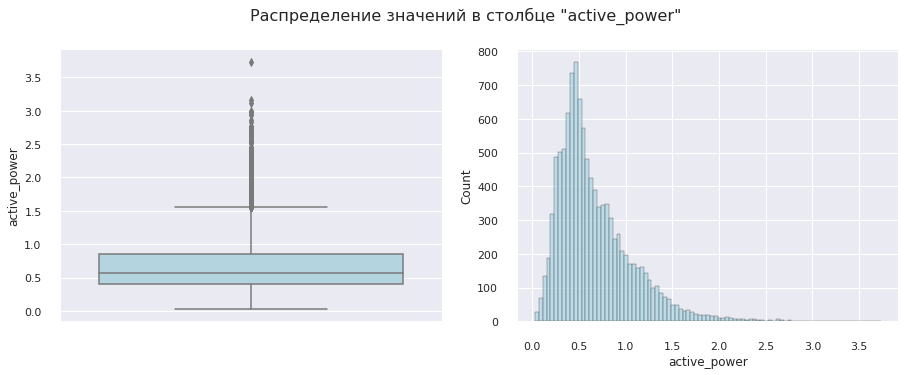

In [68]:
display(arc_raw[['active_power']].describe().T)
box_hist_distribution(arc_raw, 'active_power')

,count,mean,std,min,25%,50%,75%,max
duration_orgn,10936.0,172.001737,97.460182,11.0,107.0,147.0,216.25,907.0


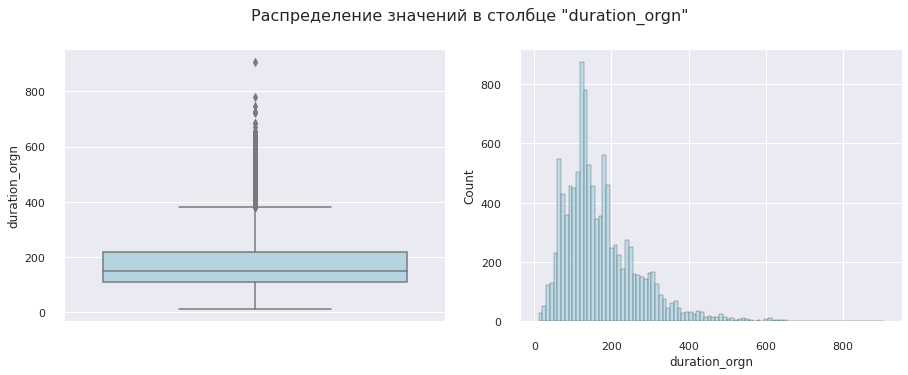

In [69]:
display(arc_raw[['duration_orgn']].describe().T)
box_hist_distribution(arc_raw, 'duration_orgn')

In [70]:
arc_raw.query('active_power > 3.5 & duration_orgn > 800')

,key,active_power,begin_heat,end_heat,duration_orgn
7458,1689,3.731596,18:49:03,19:04:10,907.0


Значение, которое видно как выброс на распредлеениях `active_power` и `duration_orgn` - это одна и та же партия `key = 1689`.

Посмотрим на парное распределение значений продолжительности нагрева `duration_orgn` и ативной мощности `active_power`

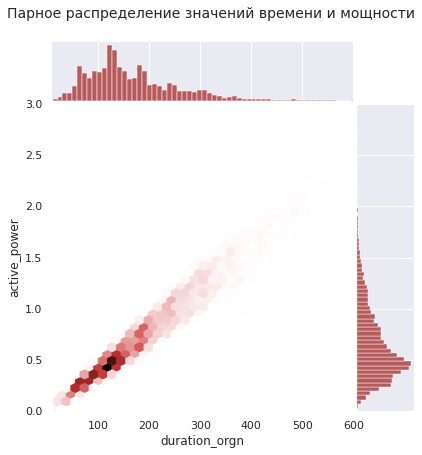

In [71]:
sns.jointplot(x=arc_raw['duration_orgn'],
              y=arc_raw['active_power'],
              height=6,
              ratio=5,
              space=0.05,
              xlim=[10, 600],
              ylim=[0, 3],
              kind='hex',
              color= 'brown')#'#4CB391')
plt.suptitle('Парное распределение значений времени и мощности',
             y = 1.05, fontsize = 14)
plt.show()

Как видно из графика выше - зависимость величин прямо пропорциональная, чем больше время нагрева, тем больше мощность.

Тут делаю **ВАЖНОЕ ДОПУЩЕНИЕ:** вполне вероятно, что в контексте задачи под `power` все-таки понимается `энергия`. Т.е. - чем бОльшее время нагрева, тем бОльше тепловой энергии было передано. И это очень хорошо согласуется с прямо пропорциональной зависимостью величин `duration_orgn` и `active_power`. Если бы `active_power` было действительно мощностью, то вряд ли наблюдалась бы такая прямо пропорциональная зависимость. Скорее была бы обратно-пропорциональная заисимость: чем с бОльшей мощностью нагревали бы, тем меньше времни уходило бы для достижение необходимой температуры.

Переведем данные из формата `time` в `datetime`. Установить значение в формате `datetime` в новых столбцах `begin_heat_dt` и `end_heat_dt` можно по правилу: если значение часа менее `12` и `key` в списке `zero_time_keys`, то присваиваем дату `TMW (завтра)`. В остальных случаях присваиваем дату `TDY (сегодня)`

In [72]:
arc_raw['begin_heat_dt'] = arc_raw.apply(
    lambda x: dt.datetime.strptime(
        ':'.join([ TMW, x['begin_heat'].strftime(FMT) ]), FMDT
    ) 
    if (x['begin_heat'].hour < 12) & (x['key'] in zero_time_keys)
    else dt.datetime.strptime(
        ':'.join([ TDY, x['begin_heat'].strftime(FMT) ]), FMDT
    ),
    axis=1
)

arc_raw['end_heat_dt'] = arc_raw.apply(
    lambda x: dt.datetime.strptime(
        ':'.join([ TMW, x['end_heat'].strftime(FMT) ]), FMDT
    ) 
    if (x['end_heat'].hour < 12) & (x['key'] in zero_time_keys)
    else dt.datetime.strptime(
        ':'.join([ TDY, x['end_heat'].strftime(FMT) ]), FMDT
    ),
    axis=1
)

Проверка для нескольких значений из списка `zero_time_keys`

In [73]:
arc_raw.query('key in @zero_time_keys')[102:117]

,key,active_power,begin_heat,end_heat,duration_orgn,begin_heat_dt,end_heat_dt
2551,584,0.356888,00:14:45,00:16:17,92.0,2000-01-02 00:14:45,2000-01-02 00:16:17
2806,641,0.262712,01:15:41,01:16:49,68.0,2000-01-02 01:15:41,2000-01-02 01:16:49
2807,641,0.567247,20:31:15,20:34:00,165.0,2000-01-01 20:31:15,2000-01-01 20:34:00
2808,641,0.983395,20:40:09,20:44:26,257.0,2000-01-01 20:40:09,2000-01-01 20:44:26
2809,641,0.650494,01:02:16,01:04:53,157.0,2000-01-02 01:02:16,2000-01-02 01:04:53
2810,641,0.542430,00:46:34,00:49:23,169.0,2000-01-02 00:46:34,2000-01-02 00:49:23
2811,641,2.371818,00:50:16,01:00:13,597.0,2000-01-02 00:50:16,2000-01-02 01:00:13
2812,642,0.965995,00:23:02,00:27:11,249.0,2000-01-02 00:23:02,2000-01-02 00:27:11
2813,642,0.488870,00:33:31,00:35:36,125.0,2000-01-02 00:33:31,2000-01-02 00:35:36
2814,642,0.533132,23:48:34,23:51:15,161.0,2000-01-01 23:48:34,2000-01-01 23:51:15


Необходимо выделить события для каждого `key`, которые произошли после первого замера температуры и до времени последнего замера температуры. 

Втом случае, если нагрев началася до времени первого замера температуры, а закончился - после, то время начала нагрева будем принимать равным времени первого замера температуры.

В том случае, если нагрев начался до времени последнего замера температуры, а закончился - после, то время завершения нагрева будем принимать равным времени последнего замера температуры. 

Объединим `arc_row` и `temp_df` по общему полю `key` и получим для каждого `key` границы времени, до которых и после которых события не учитываются.

In [74]:
arc_time_threshold = arc_raw[
    ['key', 'active_power', 'begin_heat_dt', 'end_heat_dt', 'duration_orgn']
].merge(temp_df.reset_index()[['key', 'temp_start_time_dt', 'temp_measure_time_dt']], how='right', on='key')
                     
arc_time_threshold

,key,active_power,begin_heat_dt,end_heat_dt,duration_orgn,temp_start_time_dt,temp_measure_time_dt
0,1,0.976059,2000-01-01 11:02:14,2000-01-01 11:06:02,228.0,2000-01-01 11:16:18,2000-01-01 11:30:39
1,1,0.805607,2000-01-01 11:07:28,2000-01-01 11:10:33,185.0,2000-01-01 11:16:18,2000-01-01 11:30:39
2,1,0.744363,2000-01-01 11:11:44,2000-01-01 11:14:36,172.0,2000-01-01 11:16:18,2000-01-01 11:30:39
3,1,1.659363,2000-01-01 11:18:14,2000-01-01 11:24:19,365.0,2000-01-01 11:16:18,2000-01-01 11:30:39
4,1,0.692755,2000-01-01 11:26:09,2000-01-01 11:28:37,148.0,2000-01-01 11:16:18,2000-01-01 11:30:39
...,...,...,...,...,...,...,...
10931,2498,0.892648,2000-01-01 02:12:24,2000-01-01 02:15:37,193.0,2000-01-01 02:03:49,2000-01-01 02:25:31
10932,2499,0.312893,2000-01-01 02:54:31,2000-01-01 02:55:42,71.0,2000-01-01 02:40:25,2000-01-01 03:00:28
10933,2499,1.425867,2000-01-01 02:32:56,2000-01-01 02:38:08,312.0,2000-01-01 02:40:25,2000-01-01 03:00:28
10934,2499,0.978407,2000-01-01 02:41:09,2000-01-01 02:44:34,205.0,2000-01-01 02:40:25,2000-01-01 03:00:28


Оставим только строки, для которых время последнего замера температуры больше времени начала нагрева `begin_heat_dt`.
Для оставшихся строк проверим, чтоб время окончания нагрева `end_heat_dt` было не позднее времени последнего замера температуры. Иначе - приравниваем время окончания нагрева к времени последнего замера температуры.

In [75]:
arc_time_threshold = arc_time_threshold[
    (arc_time_threshold['temp_measure_time_dt'] - arc_time_threshold['begin_heat_dt'])
    > dt.timedelta(seconds=0)]

arc_time_threshold['end_heat_dt'] = arc_time_threshold.apply(
    lambda t: t['end_heat_dt']
    if (t['temp_measure_time_dt'] - t['end_heat_dt']) >= dt.timedelta(seconds=0)
    else t['temp_measure_time_dt'], axis=1)

arc_time_threshold.query('end_heat_dt == temp_measure_time_dt')

,key,active_power,begin_heat_dt,end_heat_dt,duration_orgn,temp_start_time_dt,temp_measure_time_dt


Случаев, когда нагрев начался до времени последнего замера температуры, а закончился позднее, не обнаружено.

Оставим только строки, для которых время первого замера температуры ранее времени окончания нагрева `end_heat_dt`.
Для оставшихся строк проверим, чтоб время начала нагрева `begin_heat_dt` было позднее или равно времени первого замера температуры. Иначе - приравниваем время начала нагрева к времени первого замера температуры.

In [76]:
arc_time_threshold = arc_time_threshold[
    (arc_time_threshold['end_heat_dt'] - arc_time_threshold['temp_start_time_dt'])
    > dt.timedelta(seconds=0)]

arc_time_threshold['begin_heat_dt'] = arc_time_threshold.apply(
    lambda t: t['begin_heat_dt']
    if (t['begin_heat_dt'] - t['temp_start_time_dt']) >= dt.timedelta(seconds=0)
    else t['temp_start_time_dt'], axis=1)

arc_time_threshold.query('begin_heat_dt == temp_start_time_dt')

,key,active_power,begin_heat_dt,end_heat_dt,duration_orgn,temp_start_time_dt,temp_measure_time_dt
812,186,0.398524,2000-01-01 06:16:03,2000-01-01 06:18:01,127.0,2000-01-01 06:16:03,2000-01-01 06:37:27
7624,1725,0.451427,2000-01-01 16:28:21,2000-01-01 16:30:04,127.0,2000-01-01 16:28:21,2000-01-01 17:08:59
9202,2083,0.437409,2000-01-01 14:26:26,2000-01-01 14:27:24,134.0,2000-01-01 14:26:26,2000-01-01 14:55:41


Обнаружено `3` случая, когда нагрев начался до времени первого замера, а завершился - позднее. Для этих случаев время начала нагрева установлено на отметке первого замера температуры `temp_start_time_dt`. Для каждого из отобранных циклов нагрева заново рассчитаем продолжительность в сек., значения сохраним в столбце `duration`

In [77]:
arc_time_threshold = arc_time_threshold.assign(
    duration = lambda t: (t['end_heat_dt'] - t['begin_heat_dt'])
)
arc_time_threshold['duration'] = arc_time_threshold.apply(
    lambda s: s['duration'].total_seconds(), axis=1
)

Для каждого `key` рассчитаем суммарную энергию, переданную за все циклы нагрева, до времени последнего измерения температуры - это будет сумма всех значений `active_power`, которые были до времени последнего измерения температуры.

Поскольку есть случаи, когда мы ограничили время начала нагрева временем первого замера температуры, нам нужно скорректировать значения `active_power`, опираясь на "оригинальные данные" по продолжительности нагрева `duration_orgn` и на скорректиированную продолжительность нагрева `duration`. Если они совпадают, то коэффициент будет `1`, если не совпадают, то значение `active_power` будет пропорционально скорректировано на коэффициент `duration / duration_orgn`. Такой подход обоснован, так как заивисмость между `active_power` и `duration` прямо пропорциональная.

In [78]:
arc_time_threshold['active_power'] = arc_time_threshold.apply(
    lambda r: r['active_power'] * (r['duration']/r['duration_orgn']), axis=1
)

Например, значение `active_power` для `key = 2083` cкоректировалось: было `.437409`, стало `0.189326`. При этом видим, что время нагрева было скорректировано с `134` сек. до `58` сек.

In [79]:
arc_time_threshold.query('begin_heat_dt == temp_start_time_dt')

,key,active_power,begin_heat_dt,end_heat_dt,duration_orgn,temp_start_time_dt,temp_measure_time_dt,duration
812,186,0.370282,2000-01-01 06:16:03,2000-01-01 06:18:01,127.0,2000-01-01 06:16:03,2000-01-01 06:37:27,118.0
7624,1725,0.366118,2000-01-01 16:28:21,2000-01-01 16:30:04,127.0,2000-01-01 16:28:21,2000-01-01 17:08:59,103.0
9202,2083,0.189326,2000-01-01 14:26:26,2000-01-01 14:27:24,134.0,2000-01-01 14:26:26,2000-01-01 14:55:41,58.0


Рассчитаем суммарную переданную энергию

In [80]:
arc_df = (
    arc_time_threshold
    .groupby('key', as_index=False)
    .agg({'active_power': 'sum'})
    .rename(columns = {'active_power': 'total_energy'})
    .set_index('key')
)

arc_df

,total_energy
key,
1,2.352117
2,2.614535
3,1.463829
4,1.220955
5,1.889121
...,...
2495,2.335669
2496,3.809439
2497,1.631396


Добавим значение энергии, переданной за последний цикл нагрева

In [81]:
arc_df = arc_df.join(
    arc_time_threshold
    .groupby('key', as_index=False)
    .agg({'end_heat_dt': 'max'})
    
    .merge(arc_time_threshold, on=['key', 'end_heat_dt'], how='left')
    
    .assign(last_heat_energy = lambda e: e['active_power'])
    .set_index('key')[
        ['last_heat_energy']
    ]
)

arc_df

,total_energy,last_heat_energy
key,,
1,2.352117,0.692755
2,2.614535,0.827743
3,1.463829,0.250280
4,1.220955,1.220955
5,1.889121,0.267457
...,...,...
2495,2.335669,0.435236
2496,3.809439,1.049800
2497,1.631396,0.796857


Добавим время в минутах от завершения последнего нагрева до последнего измерения температуры

In [82]:
arc_df = arc_df.join(
    arc_time_threshold
    .groupby('key', as_index=False)
    .agg({'end_heat_dt': 'max'})
    
    .merge(arc_time_threshold[['key', 'temp_measure_time_dt', 'end_heat_dt']],
           on=['key', 'end_heat_dt'], how='inner')
    
    .assign(time_last_heat_to_measure = lambda t: t['temp_measure_time_dt'] - t['end_heat_dt'])
    .set_index('key')[
        ['time_last_heat_to_measure']
    ]
)

arc_df['minutes_last_heat_to_measure'] = arc_df.apply(
    lambda t: t['time_last_heat_to_measure'].total_seconds()/60, axis=1
)
arc_df = arc_df.drop('time_last_heat_to_measure', axis=1)
arc_df.sort_values('minutes_last_heat_to_measure')

,total_energy,last_heat_energy,minutes_last_heat_to_measure
key,,,
1134,2.945146,0.213226,0.150000
1285,2.511299,0.125759,0.166667
1196,3.099136,0.301856,0.166667
792,5.554947,0.253116,0.183333
1067,1.058541,0.218367,0.183333
...,...,...,...
2353,0.624760,0.624760,28.000000
2489,0.546101,0.546101,28.316667
1170,3.095721,0.891505,29.866667


Выведем статистику и распределения для столбцов `total_energy`, `last_heat_energy` и `minutes_last_heat_to_measure`

,count,mean,std,min,25%,50%,75%,max
total_energy,2303.0,2.553098,1.37658,0.094268,1.617933,2.391674,3.274526,17.158694


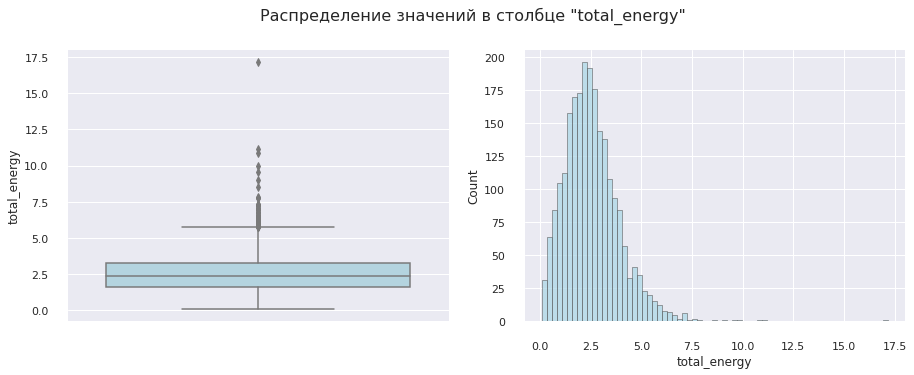

In [83]:
display(arc_df[['total_energy']].describe().T)
box_hist_distribution(arc_df, 'total_energy')

,count,mean,std,min,25%,50%,75%,max
last_heat_energy,2303.0,0.50054,0.27104,0.030002,0.305588,0.435439,0.627302,2.33705


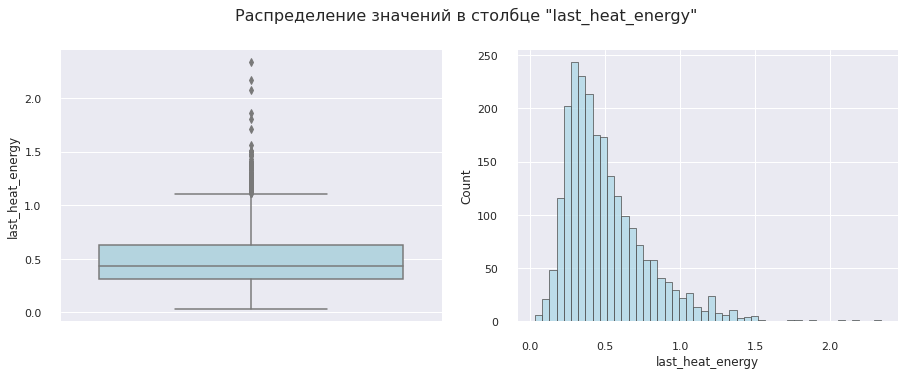

In [84]:
display(arc_df[['last_heat_energy']].describe().T)
box_hist_distribution(arc_df, 'last_heat_energy')

,count,mean,std,min,25%,50%,75%,max
minutes_last_heat_to_measure,2303.0,3.601136,4.214274,0.15,1.05,2.1,4.291667,39.3


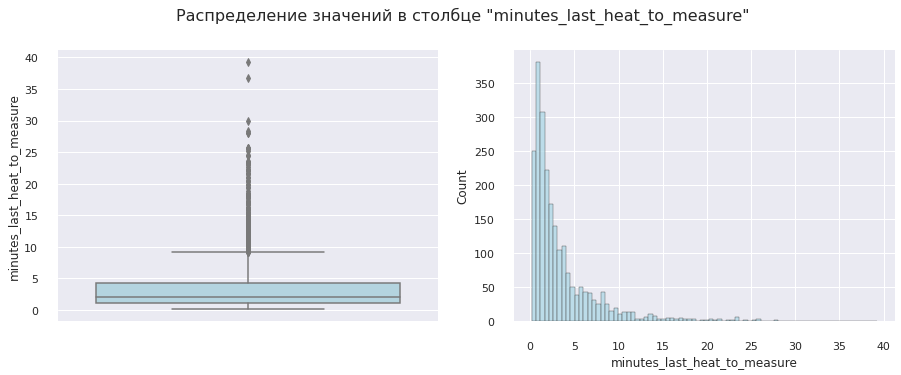

In [85]:
display(arc_df[['minutes_last_heat_to_measure']].describe().T)
box_hist_distribution(arc_df, 'minutes_last_heat_to_measure')

По результатам расмомтрения распределений для `total_energy`, `last_heat_energy` и `minutes_last_heat_to_measure` посмотрим, какие точки у нас являются выбросами, значения `key` сохраним в переменной `arc_outliers_keys`

In [86]:
arc_outliers_df = arc_df.query('total_energy >= 10 | last_heat_energy >= 1.6 | minutes_last_heat_to_measure >= 27')
arc_outliers_keys = arc_outliers_df.index
arc_outliers_df

,total_energy,last_heat_energy,minutes_last_heat_to_measure
key,,,
46,11.157055,0.434243,5.933333
487,0.730159,0.730159,39.300000
685,3.408986,1.804920,7.716667
838,2.986479,1.859735,2.500000
1089,2.539192,1.712961,1.033333
1090,2.074702,2.074702,5.516667
1170,3.095721,0.891505,29.866667
1364,4.737613,2.167326,6.783333
1664,4.998468,2.337050,3.050000


Значения `key`, у которых большое время между первым и последним замером и большое значение суммарной переданной энергии:

In [87]:
set(first_to_last_measure_outliers_keys) & set(arc_outliers_keys)

{46, 1689, 1880}

... понятно, почему для `key = 1689` самое большое время между первым и последним измернием. Как видно это значение `key` также характеризуется самым большим кол-вом суммарной переданной энергии. Передача бОльшей энергии требует бОльшего времени - все логично.

У партии `key = 1689`:
- самое большое значение суммарной переданной энергии `total_energy`
- самое большое время между первым и последним измерением `minutes_first_to_last_measure`

По точкам, у которых большие значения энергии последнего нагрева `last_heat_energy` или значение времени между окончанием последнего нагрева и последним измерением температуры `minutes_last_heat_to_measure` - ситуация пока не очень понятна. Номера партий `key` для этих выбросов есть в `arc_outliers_keys`

In [88]:
arc_df.query('last_heat_energy >= 1.6')

,total_energy,last_heat_energy,minutes_last_heat_to_measure
key,,,
685,3.408986,1.804920,7.716667
838,2.986479,1.859735,2.500000
1089,2.539192,1.712961,1.033333
1090,2.074702,2.074702,5.516667
1364,4.737613,2.167326,6.783333
1664,4.998468,2.337050,3.050000


In [89]:
arc_df.query('minutes_last_heat_to_measure >= 27')

,total_energy,last_heat_energy,minutes_last_heat_to_measure
key,,,
487,0.730159,0.730159,39.300000
1170,3.095721,0.891505,29.866667
2222,0.455137,0.455137,27.950000
2233,1.129329,1.129329,36.750000
2353,0.624760,0.624760,28.000000
2489,0.546101,0.546101,28.316667


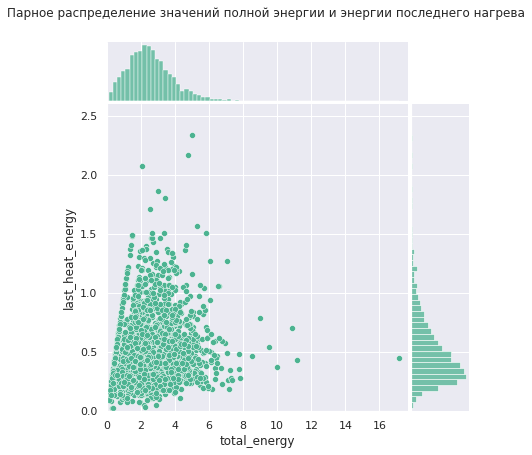

In [90]:
sns.jointplot(x=arc_df['total_energy'],
              y=arc_df['last_heat_energy'],
              height=6,
              ratio=5,
              space=0.05,
              xlim=[0, 17.7],
              ylim=[0, 2.6],
              kind='scatter',
              color= '#4CB391')
plt.suptitle('Парное распределение значений полной энергии и энергии последнего нагрева',
             y = 1.05, fontsize = 12)
plt.show()

Проверим на корреляцию

In [100]:
arc_df.corr()

,total_energy,last_heat_energy,minutes_last_heat_to_measure
total_energy,1.000000,0.128920,-0.231703
last_heat_energy,0.128920,1.000000,0.136235
minutes_last_heat_to_measure,-0.231703,0.136235,1.000000


Значения слабо скоррелированы - заберем все для признаков

#### Вывод

Сформирована таблица `arc_raw` с данными по каждому из циклов нагрева, при этом время начала и окончания каждого цикла нагрева переведено из формата `time` в формат `datetime` с устраннением проблемы "перехода через 00:00:00".

В таблице `arc_time_threshold` выделены события, произошедшие **после** времени первого и **до** времени последнего измерений температуры.

В итоговом датафрейме `arc_df` собрали значения полной переданной энергии `total_energy`, энергии последнего цикла нагрева `last_heat_energy` и времени в минутах от окончания последнего нагрева до послденего замера температуры `minutes_last_heat_to_measure` для `2303` значений `key`. Корреляция между `total_energy`, `last_heat_energy` и `minutes_last_heat_to_measure` слабая, значит все подойдут для признаков.

В переменной `arc_outliers_keys` собраны значения `key` (15 значений) для которых присутствуют выбросы в значениях `total_energy`, `last_heat_energy` и `minutes_last_heat_to_measure`

### Данные по сыпучим материалам `bulk_raw` и `bulk_time_raw`

Таблицы следует рассматривать с привязке друг к другу. Для нас важны данные из таблицы `data_bulk` по объему сыпучих материалов, которые были добавлены в каждую партию. Таблица `data_bulk_time` нужна, чтоб отфильтровать данные в `data_bulk` по времени, не ранее времени последнего замера температуры.

Если время добавления сыпучего материала для конкретной партии позднее, чем время последнего замера температуры для этой партии, то следует обнулить значение в `data_bulk` - т.е. этот сыпучий материал не добавлялся до времени последнего измерения темепературы. Если же время добавления сыпучего материала указано до времени последнего измерения температуры, то данные из таблицы `data_bulk` по этому сыпучему материалу необходимо учитывать.

**Таблица `bulk_raw`**

Оставляем только значения `key` для которых определена целевая переменная - должно остаться `2329` значений

In [101]:
bulk_raw = bulk_raw.query('key in @temp_df.index')

bulk_raw.shape

(2329, 16)

Выведем кол-во пропусков и статистику по значениям для колонок `bulk_*`:

In [102]:
bulk_raw.iloc[:, 1:].isna().sum().to_frame().join(
    bulk_raw.iloc[:, 1:].describe().T
).rename(columns={0: 'NaN_qty'})

,NaN_qty,count,mean,std,min,25%,50%,75%,max
bulk_1,2130,199.0,40.115578,18.226180,10.0,27.00,33.0,46.50,185.0
bulk_2,2316,13.0,254.846154,25.973853,228.0,242.00,248.0,258.00,325.0
bulk_3,1369,960.0,114.868750,77.485694,6.0,57.00,96.5,152.25,454.0
bulk_4,1517,812.0,106.995074,49.050943,13.0,73.00,105.0,136.25,281.0
bulk_5,2276,53.0,116.018868,95.189182,11.0,70.00,88.0,148.00,603.0
bulk_6,1891,438.0,119.269406,70.747953,17.0,72.00,100.0,155.75,503.0
bulk_7,2316,13.0,359.153846,208.804472,75.0,178.00,392.0,507.00,772.0
bulk_8,2328,1.0,49.000000,NaN,49.0,49.00,49.0,49.00,49.0
bulk_9,2316,13.0,79.692308,25.795299,63.0,66.00,68.0,71.00,147.0
bulk_10,2186,143.0,82.293706,27.788900,24.0,58.00,85.0,104.00,159.0


Кол-во пропусков во всех столбцах неоднородно, в `bulk_14` меньше всего пропусков, а в `bulk_8` только одно значение.
Пропуски, очевидно, означают, что для данного `key` не применялся данный сыпучий материал. Логично будет заполнить все пропуски значениеми `0`

По диапазону значения в столбцах более-меннее близкие; заметный "выброс" видно только в `bulk_12` (max=1849)

**Таблица `bulk_time_raw`**

Оставляем только значения `key` для которых определена целевая переменная - должно остаться `2329` значений

In [103]:
bulk_time_raw = bulk_time_raw.query('key in @temp_df.index')

bulk_time_raw.shape

(2329, 16)

Проверим, что все данные в таблицах `bulk_raw` и `bulk_time_raw` симметричны в разрезе пропусков. Это косвенно подтверждает то, что для каждого значения в `bulk_raw` есть соответствующая отметка времени в `bulk_time_raw`

In [104]:
(pd.concat([bulk_raw.isna().sum(), bulk_time_raw.isna().sum()], axis=1)
 .rename(columns=({0:'bulk_NaN', 1:'bulk_time_NaN'}))
 .assign(diff = lambda x: x['bulk_NaN']-x['bulk_time_NaN'] )
)

,bulk_NaN,bulk_time_NaN,diff
key,0,0,0
bulk_1,2130,2130,0
bulk_2,2316,2316,0
bulk_3,1369,1369,0
bulk_4,1517,1517,0
bulk_5,2276,2276,0
bulk_6,1891,1891,0
bulk_7,2316,2316,0
bulk_8,2328,2328,0
bulk_9,2316,2316,0


Трансформируем таблицу `bulk_time_raw` методом `pd.melt()` в таблицу `bulk_time_melt`. В таком виде гораздо удобней провести операции:
- перевод времени из формата `time` в `datetime`
- отфильтровать только события, произошедшие до времени последнего измерения температуры

In [105]:
bulk_time_melt = (pd.melt(frame=bulk_time_raw,
                          id_vars=['key'],
                          var_name='bulk_type',
                          value_name='time')
                  .sort_values(['key', 'bulk_type'])
                  .dropna(subset=['time'], axis=0)
)

bulk_time_melt

,key,bulk_type,time
25619,1,bulk_12,11:03:52
30277,1,bulk_14,11:03:52
32606,1,bulk_15,11:03:52
6987,1,bulk_4,11:21:30
25620,2,bulk_12,11:40:20
...,...,...,...
6985,2498,bulk_3,02:05:26
27947,2499,bulk_12,02:35:52
32605,2499,bulk_14,02:35:52
34934,2499,bulk_15,02:35:52


In [106]:
bulk_time_melt['key'].nunique()

2329

Установим значение в формате `datetime` в столбце `bulk_time_dt` по правилу: если значение часа менее `12` и `key` в списке `zero_time_keys`, то присваиваем дату `TMW (завтра)`. В остальных случаях присваиваем дату `TDY (сегодня)`

In [107]:
bulk_time_melt['bulk_time_dt'] = bulk_time_melt.apply(
    lambda x: dt.datetime.strptime(
        ':'.join([ TMW, x['time'].strftime(FMT) ]), FMDT
    ) 
    if (x['time'].hour < 12) & (x['key'] in zero_time_keys)  
    else dt.datetime.strptime(
        ':'.join([ TDY, x['time'].strftime(FMT) ]), FMDT
    ),
    axis=1
)

bulk_time_melt

,key,bulk_type,time,bulk_time_dt
25619,1,bulk_12,11:03:52,2000-01-01 11:03:52
30277,1,bulk_14,11:03:52,2000-01-01 11:03:52
32606,1,bulk_15,11:03:52,2000-01-01 11:03:52
6987,1,bulk_4,11:21:30,2000-01-01 11:21:30
25620,2,bulk_12,11:40:20,2000-01-01 11:40:20
...,...,...,...,...
6985,2498,bulk_3,02:05:26,2000-01-01 02:05:26
27947,2499,bulk_12,02:35:52,2000-01-01 02:35:52
32605,2499,bulk_14,02:35:52,2000-01-01 02:35:52
34934,2499,bulk_15,02:35:52,2000-01-01 02:35:52


Проверим конвертацию для нескольких значений `key` из списка `zero_time_keys`

In [108]:
bulk_time_melt.query('key in @zero_time_keys').sort_values('key')[:15]

,key,bulk_type,time,bulk_time_dt
25636,18,bulk_12,23:29:10,2000-01-01 23:29:10
30294,18,bulk_14,23:29:10,2000-01-01 23:29:10
32623,18,bulk_15,23:29:10,2000-01-01 23:29:10
11662,18,bulk_6,23:53:11,2000-01-01 23:53:11
25660,44,bulk_12,00:39:35,2000-01-02 00:39:35
27989,44,bulk_13,00:39:35,2000-01-02 00:39:35
30318,44,bulk_14,22:15:42,2000-01-01 22:15:42
32647,44,bulk_15,00:39:35,2000-01-02 00:39:35
11686,44,bulk_6,22:33:48,2000-01-01 22:33:48
25661,45,bulk_12,23:32:13,2000-01-01 23:32:13


Объединяем с таблицой `time_dt`, маркируем флагом `1` строки в которых время загрузки сыпучего материала `bulk_time_dt` больше времени первого измерения `temp_start_time_dt` и меньше времени последнего измерения температуры `temp_measure_time_dt` , если же не выполняется - ставим `0`

In [109]:
bulk_time_threshold = bulk_time_melt[
    ['key', 'bulk_type', 'bulk_time_dt']
].merge(temp_df.reset_index()[['key', 'temp_start_time_dt', 'temp_measure_time_dt']], how='left', on='key')
                     
bulk_time_threshold['check_flag'] = bulk_time_threshold.apply(
    lambda x: 1 
    if (
        ((x['temp_measure_time_dt'] - x['bulk_time_dt']) >= dt.timedelta(seconds=0)) 
      & ((x['bulk_time_dt'] - x['temp_start_time_dt']) >= dt.timedelta(seconds=0))
       )
    else 0,
    axis=1
)

bulk_time_threshold

,key,bulk_type,bulk_time_dt,temp_start_time_dt,temp_measure_time_dt,check_flag
0,1,bulk_12,2000-01-01 11:03:52,2000-01-01 11:16:18,2000-01-01 11:30:39,0
1,1,bulk_14,2000-01-01 11:03:52,2000-01-01 11:16:18,2000-01-01 11:30:39,0
2,1,bulk_15,2000-01-01 11:03:52,2000-01-01 11:16:18,2000-01-01 11:30:39,0
3,1,bulk_4,2000-01-01 11:21:30,2000-01-01 11:16:18,2000-01-01 11:30:39,1
4,2,bulk_12,2000-01-01 11:40:20,2000-01-01 11:37:27,2000-01-01 11:59:12,1
...,...,...,...,...,...,...
8363,2498,bulk_3,2000-01-01 02:05:26,2000-01-01 02:03:49,2000-01-01 02:25:31,1
8364,2499,bulk_12,2000-01-01 02:35:52,2000-01-01 02:40:25,2000-01-01 03:00:28,0
8365,2499,bulk_14,2000-01-01 02:35:52,2000-01-01 02:40:25,2000-01-01 03:00:28,0
8366,2499,bulk_15,2000-01-01 02:35:52,2000-01-01 02:40:25,2000-01-01 03:00:28,0


трансформируем таблицу `bulk_raw` в `bulk_melt`

In [110]:
bulk_melt = (
    pd.melt(
        frame=bulk_raw, id_vars='key', var_name='bulk_type', value_name='bulk_volume'
    )
    .sort_values('key')
    .dropna(subset=['bulk_volume'], axis=0)
)

bulk_melt

,key,bulk_type,bulk_volume
6987,1,bulk_4,43.0
32606,1,bulk_15,154.0
30277,1,bulk_14,150.0
25619,1,bulk_12,206.0
30278,2,bulk_14,149.0
...,...,...,...
6985,2498,bulk_3,90.0
32605,2499,bulk_14,126.0
27947,2499,bulk_12,233.0
6986,2499,bulk_3,47.0


Объединяем `bulk_time_threshold` и `bulk_melt` по полям `key` и `bulk_type`, создаем новое поле `bulk_volume_checked`, в котором будет значение объема сыпучего материала, если он добавлялся до времени последнего измерения температуры, или будет стоять `0`, если добавление сыпучего материала было после времени последнего измерения температуры.

In [111]:
bulk_prep = (
    bulk_time_threshold[['key', 'bulk_type', 'check_flag']]
    .merge(bulk_melt, on=['key', 'bulk_type'])
    .assign(bulk_volume_checked=lambda x: x['bulk_volume'] * x['check_flag'])
)

bulk_prep

,key,bulk_type,check_flag,bulk_volume,bulk_volume_checked
0,1,bulk_12,0,206.0,0.0
1,1,bulk_14,0,150.0,0.0
2,1,bulk_15,0,154.0,0.0
3,1,bulk_4,1,43.0,43.0
4,2,bulk_12,1,206.0,206.0
...,...,...,...,...,...
8363,2498,bulk_3,1,90.0,90.0
8364,2499,bulk_12,0,233.0,0.0
8365,2499,bulk_14,0,126.0,0.0
8366,2499,bulk_15,0,227.0,0.0


Возвращаемся в исходный формат таблицы

In [112]:
bulk_df = pd.pivot_table(
    data=bulk_prep,
    index='key',
    columns='bulk_type',
    values='bulk_volume_checked'
).rename_axis(columns=None)

bulk_df

,bulk_1,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9
key,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,206.0,NaN,149.0,154.0,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,NaN,90.0,NaN,0.0,NaN,0.0,0.0,NaN,21.0,NaN,NaN,NaN,NaN,NaN,NaN
2496,NaN,122.0,NaN,256.0,NaN,129.0,226.0,NaN,NaN,63.0,NaN,NaN,NaN,NaN,NaN
2497,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,NaN,85.0,NaN,NaN,NaN,NaN,NaN


In [113]:
bulk_df.describe().T.sort_values('count')

,count,mean,std,min,25%,50%,75%,max
bulk_8,1.0,49.000000,NaN,49.0,49.00,49.0,49.00,49.0
bulk_2,13.0,254.846154,25.973853,228.0,242.00,248.0,258.00,325.0
bulk_7,13.0,359.153846,208.804472,75.0,178.00,392.0,507.00,772.0
bulk_9,13.0,79.692308,25.795299,63.0,66.00,68.0,71.00,147.0
bulk_13,14.0,166.428571,69.213954,0.0,153.00,154.0,158.50,305.0
bulk_5,53.0,114.867925,96.457651,0.0,70.00,88.0,148.00,603.0
bulk_11,130.0,71.892308,61.680880,0.0,21.25,50.5,102.25,313.0
bulk_10,143.0,77.727273,31.361855,0.0,56.00,82.0,101.00,154.0
bulk_1,199.0,36.035176,22.078688,0.0,27.00,31.0,46.00,185.0
bulk_6,438.0,109.737443,73.456237,0.0,64.00,91.5,148.25,503.0


In [114]:
bulk_df = bulk_df.fillna(0)

#### Вывод

Сформирована таблица `bulk_df` в которой собраны данные для каждой партии `key` по объему сыпучего материала, поступившего  **после** времения первого измерения температуры и **до** времени последнего измерения температуры.

Данные есть для `2329` значений `key`. Если сыпучий материал добавлялся **до** времени первого измерния или **после** времени последнего измерения темепартуры, то значение объема установлено в `0` (не учитывается).

Кол-во значений в столбцах `bulk_*` от `1` (bulk_8) до `2068` (bulk_14).

Пропуски заполнены значением `0`.

### Данные по проволочным материалам `wire_raw` и `wire_time_raw`

Для данных по проволочным материалам целесообразно провести такие же действия, как и с данными по сыпучим материалам. Пояснений будет меньше, так как логика описана выше в разделе `3.6.3`

**Таблица `wire_raw`**

Оставляем только значения `key` для которых определена целевая переменная - должно остаться `2329` значений

In [115]:
wire_raw = wire_raw.query('key in @temp_df.index')
wire_raw.shape

(2329, 10)

In [116]:
wire_raw.iloc[:, 1:].isna().sum().to_frame().join(
    wire_raw.iloc[:, 1:].describe().T
).rename(columns={0: 'NaN'})

,NaN,count,mean,std,min,25%,50%,75%,max
wire_1,23,2306.0,103.465371,42.530971,1.918800,75.042236,102.053638,128.220310,330.314424
wire_2,1518,811.0,50.571346,39.755956,0.030160,20.193680,40.112801,69.699761,282.780152
wire_3,2290,39.0,193.182538,100.867783,0.144144,93.189102,236.972740,277.068801,385.008668
wire_4,2317,12.0,59.496235,30.804638,24.148801,38.347402,49.661561,84.755579,113.231044
wire_5,2329,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
wire_6,2284,45.0,50.659374,37.743040,0.137280,25.053600,40.085762,65.036400,180.454575
wire_7,2325,4.0,3.703414,3.818433,0.234208,0.849004,3.044704,5.899114,8.490040
wire_8,2316,13.0,55.772561,20.235591,45.076721,46.002319,46.187439,46.279999,102.762401
wire_9,2305,24.0,30.773167,15.210141,4.622800,20.802601,30.066399,40.495001,62.025600


Во всех столбцах, кроме `wire_5` есть данные. Минимальное кол-во `4` в столбце `wire_7`, максимальное `2306` - в столбце `wire_1`. Данные достаточно однородные в рамках каждого из столбцов, "выбросов" нет

**Таблица `wire_time`**

Оставляем только значения `key` для которых определена целевая переменная - должно остаться `2329` значений

In [117]:
wire_time_raw = wire_time_raw.query('key in @temp_df.index')
wire_time_raw.shape

(2329, 10)

In [118]:
(pd.concat([wire_raw.isna().sum(), wire_time_raw.isna().sum()], axis=1)
 .rename(columns=({0:'wire_NaN', 1:'wire_time_NaN'}))
 .assign(diff = lambda x: x['wire_NaN']-x['wire_time_NaN'] )
)

,wire_NaN,wire_time_NaN,diff
key,0,0,0
wire_1,23,23,0
wire_2,1518,1518,0
wire_3,2290,2290,0
wire_4,2317,2317,0
wire_5,2329,2329,0
wire_6,2284,2284,0
wire_7,2325,2325,0
wire_8,2316,2316,0
wire_9,2305,2305,0


Трансформируем таблицу `wire_raw` методом `pd.melt()`

In [119]:
wire_time_melt = (pd.melt(frame=wire_time_raw,
                          id_vars=['key'],
                          var_name='wire_type',
                          value_name='time')
                  .sort_values(['key', 'wire_type'])
                  .dropna(subset=['time'], axis=0)
)

wire_time_melt

,key,wire_type,time
0,1,wire_1,11:11:41
1,2,wire_1,11:46:10
2,3,wire_1,12:13:47
3,4,wire_1,12:48:05
4,5,wire_1,13:18:15
...,...,...,...
2326,2497,wire_1,01:42:27
4655,2497,wire_2,01:42:51
2327,2498,wire_1,02:04:20
2328,2499,wire_1,02:39:57


Устанавливаем значение в формате `datetime` в столбце `wire_time_dt`, добавляем данные по времени последнего замера температуры, устанавливаем `check_flag`

In [120]:
wire_time_melt['wire_time_dt'] = wire_time_melt.apply(
    lambda x: dt.datetime.strptime(
        ':'.join([ TMW, x['time'].strftime(FMT) ]), FMDT
    ) 
    if (x['time'].hour < 12) & (x['key'] in zero_time_keys)  
    else dt.datetime.strptime(
        ':'.join([ TDY, x['time'].strftime(FMT) ]), FMDT
    ),
    axis=1
)

wire_time_threshold = wire_time_melt[
    ['key', 'wire_type', 'wire_time_dt']
].merge(temp_df.reset_index()[['key', 'temp_start_time_dt', 'temp_measure_time_dt']], how='left', on='key')
                     
wire_time_threshold['check_flag'] = wire_time_threshold.apply(
    lambda x: 1 
    if (
        ((x['temp_measure_time_dt'] - x['wire_time_dt']) >= dt.timedelta(seconds=0)) 
      & ((x['wire_time_dt'] - x['temp_start_time_dt']) >= dt.timedelta(seconds=0))
       )
    else 0,
    axis=1
)

wire_time_threshold

,key,wire_type,wire_time_dt,temp_start_time_dt,temp_measure_time_dt,check_flag
0,1,wire_1,2000-01-01 11:11:41,2000-01-01 11:16:18,2000-01-01 11:30:39,0
1,2,wire_1,2000-01-01 11:46:10,2000-01-01 11:37:27,2000-01-01 11:59:12,1
2,3,wire_1,2000-01-01 12:13:47,2000-01-01 12:13:17,2000-01-01 12:34:57,1
3,4,wire_1,2000-01-01 12:48:05,2000-01-01 12:52:57,2000-01-01 12:59:25,0
4,5,wire_1,2000-01-01 13:18:15,2000-01-01 13:23:19,2000-01-01 13:36:01,0
...,...,...,...,...,...,...
3249,2497,wire_1,2000-01-01 01:42:27,2000-01-01 01:41:53,2000-01-01 01:53:50,1
3250,2497,wire_2,2000-01-01 01:42:51,2000-01-01 01:41:53,2000-01-01 01:53:50,1
3251,2498,wire_1,2000-01-01 02:04:20,2000-01-01 02:03:49,2000-01-01 02:25:31,1
3252,2499,wire_1,2000-01-01 02:39:57,2000-01-01 02:40:25,2000-01-01 03:00:28,0


Объединяем `wire_time_threshold` и `wire_melt` по полям `key` и `wire_type`, создаем новое поле `wire_volume_checked`, в котором будет значение объема проволочного материала, если он добавлялся до времени последнего измерения температуры, или будет стоять `0`, если добавление было после времени последнего измерения температуры.

In [121]:
wire_melt = (
    pd.melt(
        frame=wire_raw, id_vars='key', var_name='wire_type', value_name='wire_volume'
    )
    .sort_values('key')
    .dropna(subset=['wire_volume'], axis=0)
)

wire_prep = (
    wire_time_threshold[['key', 'wire_type', 'check_flag']]
    .merge(wire_melt, on=['key', 'wire_type'])
    .assign(wire_volume_checked=lambda x: x['wire_volume'] * x['check_flag'])
)

wire_prep

,key,wire_type,check_flag,wire_volume,wire_volume_checked
0,1,wire_1,0,60.059998,0.000000
1,2,wire_1,1,96.052315,96.052315
2,3,wire_1,1,91.160157,91.160157
3,4,wire_1,0,89.063515,0.000000
4,5,wire_1,0,89.238236,0.000000
...,...,...,...,...,...
3249,2497,wire_1,1,94.086723,94.086723
3250,2497,wire_2,1,9.048000,9.048000
3251,2498,wire_1,1,118.110717,118.110717
3252,2499,wire_1,0,110.160958,0.000000


Возвращаемся в исходный формат таблицы, выводим статистику

In [122]:
wire_df = pd.pivot_table(
    data=wire_prep,
    index='key',
    columns='wire_type',
    values='wire_volume_checked'
).rename_axis(columns=None)

wire_df.describe().T.sort_values('count')

,count,mean,std,min,25%,50%,75%,max
wire_7,4.0,3.703414,3.818433,0.234208,0.849004,3.044704,5.899114,8.490040
wire_4,12.0,56.731048,34.632885,0.000000,36.335002,49.661561,84.755579,113.231044
wire_8,13.0,55.772561,20.235591,45.076721,46.002319,46.187439,46.279999,102.762401
wire_9,24.0,29.791884,16.408810,0.000000,16.543800,30.066399,40.495001,62.025600
wire_3,39.0,186.914121,105.104035,0.000000,93.165077,231.591369,277.068801,385.008668
wire_6,45.0,47.434057,35.627948,0.000000,25.053600,40.051441,64.212723,180.454575
wire_2,811.0,46.871256,39.771462,0.000000,18.096001,35.136398,64.384319,282.780152
wire_1,2306.0,95.781749,50.260560,0.000000,65.145600,100.058403,126.224275,330.314424


Заполняем пропуски

In [123]:
wire_df = wire_df.fillna(0)

In [124]:
wire_df

,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9
key,,,,,,,,
1,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
5,0.000000,9.11456,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2495,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2496,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2497,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0


#### Вывод

Сформирована таблица `wire_df` в которой собраны данные для каждой партии `key` по объему проволочного материала, поступившего **до** времени последнего измерения температуры. Данные есть для `2329` значений `key`. Если проволочный материал добавлялся **после** времени последнего замера темепартуры, то значение объема установлено в `0` (не учитывается).

Пропуски заполнены значением `0`, в столбце `wire_5` изначально значения отсутствовали, он самоликвидировался.

### Данные по продувке сплава газом `gas_raw`

Оставляем только значения `key` для которых определена целевая переменная - должно остаться `2329` значений

In [125]:
gas_raw = gas_raw.query('key in @temp_df.index')
gas_raw.shape

(2329, 2)

In [126]:
gas_raw.iloc[:, 1:].describe().T

,count,mean,std,min,25%,50%,75%,max
gas,2329.0,11.3756,6.392041,0.008399,7.282948,10.10095,14.216688,77.99504


In [127]:
gas_raw.isna().sum()

key    0
gas    0
dtype: int64

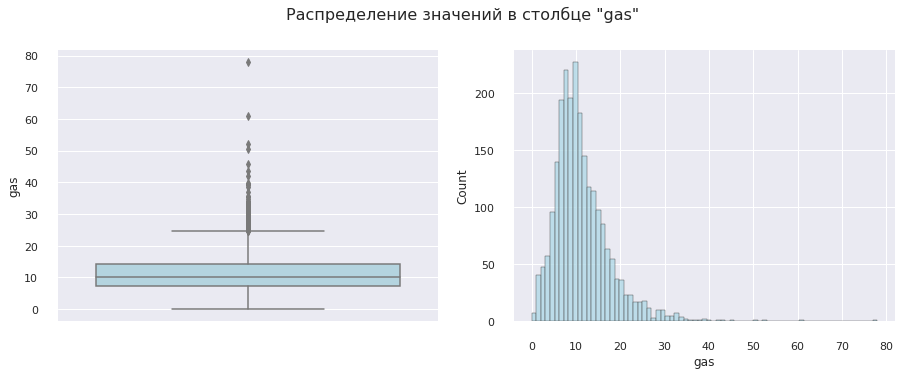

In [128]:
box_hist_distribution(gas_raw, 'gas')

В `gas` присутствуют выбросы. Попробуем разобраться, почему такие значения...

In [132]:
gas_outliers_keys = gas_raw.query('gas > 49')['key'].values
gas_raw.query('key in @gas_outliers_keys')

,key,gas
98,117,50.581035
248,280,60.935689
289,322,77.995040
1975,2110,52.142373


In [133]:
set(gas_outliers_keys) & set(first_to_last_measure_outliers_keys)

{322, 2110}

In [134]:
temp_df.loc[first_to_last_measure_outliers_keys, :][
    ['minutes_first_to_last_measure']
].join(gas_raw.query('key in @gas_outliers_keys').set_index('key'), how='right').dropna()

,minutes_first_to_last_measure,gas
key,,
322,112.083333,77.995040
2110,98.650000,52.142373


... теперь понятно - скорее всего объемная продувка газом и есть причина большого времени м/у первым и последним измерением температуры, т.к. значения `key = 322` и `key = 2110` присутствуют в спиcках `first_to_last_measure_outliers_keys` и `gas_outliers_keys`

In [135]:
gas_df = gas_raw.set_index('key')

#### Вывод

В итоговом датафрейме `gas_df` собраны `2329` значения по продувке газом. 
В переменной `gas_outliers_keys` собраны значения `key` (4 значения) для которых присутствуют выбросы в значениях `gas`

### Объединение данных в общую таблицу

Объединим таблицы `arc_df`, `bulk_df`, `wire_df`, `gas_df` и `temp_df` методом `pd.concat`, сохраним результат в переменной `df`

In [136]:
df = pd.concat([
    arc_df[['total_energy', 'last_heat_energy', 'minutes_last_heat_to_measure']],
    bulk_df,
    wire_df,
    gas_df,
    temp_df[['temp_fch', 'minutes_first_to_last_measure', 'temp_trgt']]
],
               axis=1)

df.isna().sum().sort_values(ascending=False)

total_energy                     26
minutes_last_heat_to_measure     26
last_heat_energy                 26
bulk_8                            0
minutes_first_to_last_measure     0
temp_fch                          0
gas                               0
wire_9                            0
wire_8                            0
wire_7                            0
wire_6                            0
wire_4                            0
wire_3                            0
wire_2                            0
wire_1                            0
bulk_9                            0
bulk_7                            0
bulk_6                            0
bulk_5                            0
bulk_4                            0
bulk_3                            0
bulk_2                            0
bulk_15                           0
bulk_14                           0
bulk_13                           0
bulk_12                           0
bulk_11                           0
bulk_10                     

После объединения образовались пропуски в столбцах `total_energy`, `last_heat_energy`, `minutes_last_heat_to_measure` - по `26` пропусков.

Все верно: в таблице `arc_df` после фильтрации по времени было `2303` значения `key`. В остальных таблицах у нас по `2329` значений `key`, разница - 26


Строки, в которых есть пропуски - удалим.

In [137]:
df = df.dropna()
df.shape

(2303, 30)

Выполним оценку мультиколлинеарности

In [138]:
def corr_matrix_heatmap(data, title, res = '.1f'):
    fig, ax = plt.subplots(figsize=(12, 9))
    sns.heatmap(data,
                annot=True,
                fmt=res,
                center=.6,
                linewidths=.6,
                annot_kws={'fontsize': 8},
                ax=ax
               )
    ax.set_title(title, fontsize=16)
    plt.show()

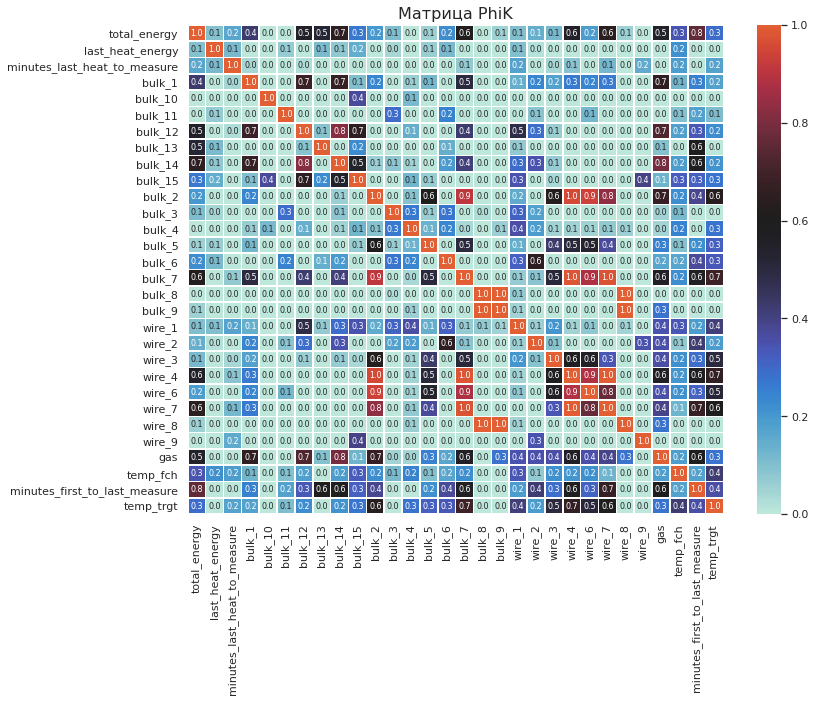

In [140]:
corr_matrix_heatmap(df.phik_matrix(verbose=False), 'Матрица PhiK')

Строим матрицу `PhiK` для признаков, у которых корреляция с целевым признаком более `0.2`

In [144]:
best_corr_features = df.phik_matrix(verbose=False)['temp_trgt'][
    df.phik_matrix(verbose=False)['temp_trgt'] > .2 
][:-1].index

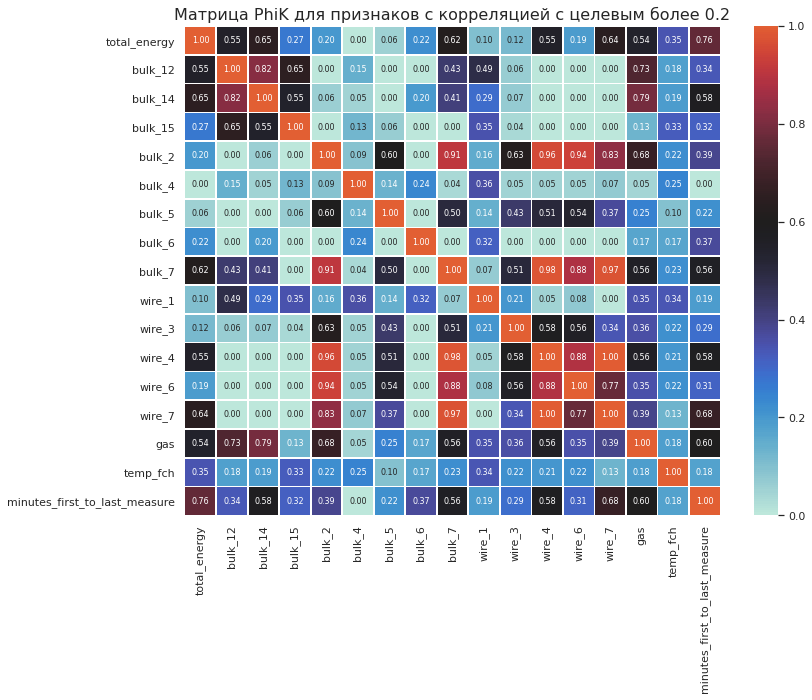

In [145]:
corr_matrix_heatmap(df[best_corr_features].phik_matrix(verbose=False),
                    'Матрица PhiK для признаков с корреляцией с целевым более 0.2',
                    '.2f')

Обозначим критические пересечения (левая половина, смотрим "сверху-вниз"):
- `bulk_14` / `bulk_12` (значение `0.82`)
- `bulk_7`, `wire_4`, `wire_6`, `wire_7` / `bulk_2` (значения `0.91`, `0.96`, `0.94`, `0.83` соотв.)
- `wire_4`, `wire_6`, `wire_7` / `bulk_7` (значения `0.98`, `0.88`, `0.97` соотв.)
- `wire_7` / `wire_4` (значение `1.0`)

In [146]:
display(df[df['wire_7']>0][['wire_7']].describe().T)
display(df[df['wire_4']>0][['wire_4']].describe().T)

,count,mean,std,min,25%,50%,75%,max
wire_7,4.0,3.703414,3.818433,0.234208,0.849004,3.044704,5.899114,8.49004


,count,mean,std,min,25%,50%,75%,max
wire_4,11.0,61.888416,31.117213,24.148801,41.567242,56.07888,87.36052,113.231044


Убираем все, что больше 0.9: `bulk_2`, `bulk_7` и `wire_7` (у `wire_7` меньше ненулевых значений, чем у `wire_4`)

In [147]:
best_corr_features = best_corr_features.drop(['bulk_2', 'bulk_7', 'wire_7'])

In [148]:
df = df[best_corr_features.union(['temp_trgt'])]

Матрица `PhiK` после фильтрация признаков, по которым наблюдается корреляция более `0.2` с целевым

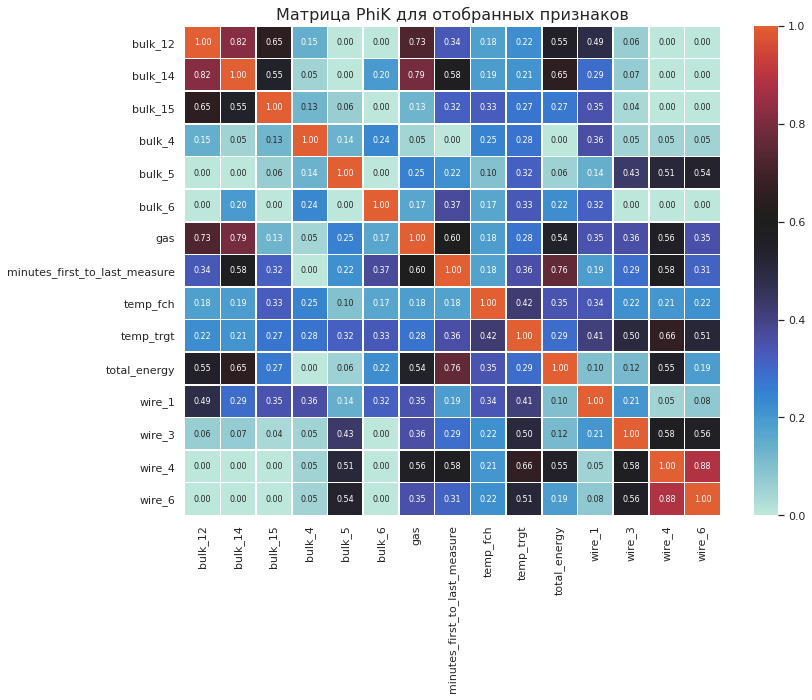

In [149]:
corr_matrix_heatmap(df.phik_matrix(verbose=False),
                    'Матрица PhiK для отобранных признаков',
                    '.2f')

In [152]:
df.shape

(2303, 15)

## Вывод

По итогам **EDA** подготовлен датасет, содержащий `14` признаков и целевую переменную. Данные сохранены в переменной `df`, целевой признак в столбце `temp_trgt`. Размерность данных `2303 rows × 15 columns`

# Поиск лучшей модели

В данном разделе найдем лучшую модель прогнозирования последней измеренной температуры. В качестве критерия оценки качества модели используем метрику `MAE`. По условиям задания необходимо рассмотреть следующие классы моделей:
- решающее дерево,
- бустинги,
- нейронную сеть.

Поскольку у нас задача регресии, то рассомтрим такие модели:
- `RandomForestRegressor`
- `CatBoostRegressor`
- FC нейронная сеть (библиотека `Keras`)

## Разделение данных

Разделим данные на `тренировочную`, `валидационную` и `тестовую` выборки в соотношении `TRN_SZE`, `VAL_SZE` и `TST_SZE` от общего объема данных соответственно.

In [153]:
df_target = df['temp_trgt']
df_features = df.drop('temp_trgt', axis=1)
    
features, X_test, target, y_test = train_test_split(
    df_features,
    df_target,
    test_size=TST_SZE,
    random_state=RND_ST,
    shuffle=True
)

X_train, X_val, y_train, y_val = train_test_split(
    features,
    target,
    test_size=(VAL_SZE / (TRN_SZE + TST_SZE)),
    random_state=RND_ST,
    shuffle=True,
)

In [154]:
df.shape[0], X_train.shape[0], X_val.shape[0], X_test.shape[0]

(2303, 1611, 346, 346)

In [157]:
del temp_raw
del arc_raw
del bulk_raw
del bulk_time_raw
del wire_raw
del wire_time_raw
del df_target
del df_features
del data_for_anomaly_test
del arc_time
del temp_time
del bulk_time
del wire_time

## Модель `RandomForestRegressor`

Подберем гиперпараметры модели с помощью `Optuna`. Гиперпараметры лучшй модели сохраним в `best_params_rf`.

In [158]:
def objective_RF(trial, X_trn=X_train.values, y_trn=y_train.values, X_vld=X_val.values, y_vld=y_val.values):
    
    params = { 
              'n_estimators': trial.suggest_int('n_estimators', 1066, 1068),       # исследовал 100, 1500
              'max_depth': trial.suggest_int('max_depth', 15, 15),                 # исследовал 7, 25
              'min_samples_split': trial.suggest_int('min_samples_split', 3, 4),   # исследовал 2, 5
              'max_features': trial.suggest_int('max_features', 13, 14)            # исследовал 5, 14
             }
    
    model = RandomForestRegressor(**params, random_state=RND_ST)
    model.fit(X_trn, y_trn)
    
    return mean_absolute_error(y_vld, model.predict(X_vld))

In [159]:
study_rf = optuna.create_study(direction = 'minimize', study_name='RandomForest')
study_rf.optimize(objective_RF, n_trials = 5)                                    # исcледовал 100

[I 2023-01-12 09:54:28,013] A new study created in memory with name: RandomForest
[I 2023-01-12 09:54:36,609] Trial 0 finished with value: 6.092420979375225 and parameters: {'n_estimators': 1068, 'max_depth': 15, 'min_samples_split': 3, 'max_features': 14}. Best is trial 0 with value: 6.092420979375225.
[I 2023-01-12 09:54:46,231] Trial 1 finished with value: 6.0928298766034015 and parameters: {'n_estimators': 1067, 'max_depth': 15, 'min_samples_split': 3, 'max_features': 14}. Best is trial 0 with value: 6.092420979375225.
[I 2023-01-12 09:54:54,316] Trial 2 finished with value: 6.107305651445728 and parameters: {'n_estimators': 1067, 'max_depth': 15, 'min_samples_split': 3, 'max_features': 13}. Best is trial 0 with value: 6.092420979375225.
[I 2023-01-12 09:55:02,272] Trial 3 finished with value: 6.106090706988182 and parameters: {'n_estimators': 1068, 'max_depth': 15, 'min_samples_split': 4, 'max_features': 13}. Best is trial 0 with value: 6.092420979375225.
[I 2023-01-12 09:55:10,74

In [160]:
study_rf.best_params

{'n_estimators': 1068,
 'max_depth': 15,
 'min_samples_split': 3,
 'max_features': 14}

In [161]:
study_rf.best_trial.value

6.092420979375225

Сохраняем оптимальные гиперпараметры

In [162]:
best_params_rf = study_rf.best_params
best_params_rf.update({'criterion': 'absolute_error'})

Для модели `RandomForestRegressor` найдены оптимальные гиперпараметры, которые сохранены в переменной `best_params_rf`.

## Модель `CatBoostRegressor`

Подберем гиперпараметры модели с помощью `Optuna`. Гиперпараметры лучшй модели сохраним в `best_params_cbr`.

In [163]:
def objective_CBR(trial, X_train=X_train.values, y_train=y_train.values, X_val=X_val.values, y_val=y_val.values):
    
    params = {'max_depth': trial.suggest_int('max_depth', 3, 3),                       # исследовал 3, 7
              'learning_rate': trial.suggest_float('learning_rate', 0.08768, 0.0877),  # исcледовал .001, .1
              'n_estimators': trial.suggest_int('n_estimators', 1125, 1127),           # исследовал 100, 1500
              'loss_function': 'MAE',
              'eval_metric': 'MAE'
             }
    
    model = CatBoostRegressor(**params, random_state=RND_ST)
                               
    model.fit(X_train, y_train,
              eval_set=[(X_val, y_val)],
              early_stopping_rounds=100,
              verbose=False)
    
    return model.get_best_score()['validation']['MAE']

In [164]:
study_cbr = optuna.create_study(direction = 'minimize', study_name='CatBoost')
study_cbr.optimize(objective_CBR, n_trials = 20)                                      # исследовал 500

[I 2023-01-12 09:55:10,799] A new study created in memory with name: CatBoost
[I 2023-01-12 09:55:12,009] Trial 0 finished with value: 5.659327148864053 and parameters: {'max_depth': 3, 'learning_rate': 0.0876874537452264, 'n_estimators': 1127}. Best is trial 0 with value: 5.659327148864053.
[I 2023-01-12 09:55:13,369] Trial 1 finished with value: 5.61551222796197 and parameters: {'max_depth': 3, 'learning_rate': 0.08768044173113757, 'n_estimators': 1126}. Best is trial 1 with value: 5.61551222796197.
[I 2023-01-12 09:55:15,283] Trial 2 finished with value: 5.397619414619505 and parameters: {'max_depth': 3, 'learning_rate': 0.08769195992992541, 'n_estimators': 1126}. Best is trial 2 with value: 5.397619414619505.
[I 2023-01-12 09:55:17,330] Trial 3 finished with value: 5.611037336858771 and parameters: {'max_depth': 3, 'learning_rate': 0.08768186348213303, 'n_estimators': 1125}. Best is trial 2 with value: 5.397619414619505.
[I 2023-01-12 09:55:19,691] Trial 4 finished with value: 5.40

In [165]:
study_cbr.best_params

{'max_depth': 3, 'learning_rate': 0.08769195992992541, 'n_estimators': 1126}

In [166]:
study_cbr.best_trial.value

5.397619414619505

Сохраняем лучшие гиперпараметры в переменную `best_params_cbr`

In [167]:
best_params_cbr = study_cbr.best_params
best_params_cbr.update({'loss_function': 'MAE',
                        'eval_metric': 'MAE',
                        'random_state': RND_ST,
                        'verbose': False})

Для модели `CatBoostRegressor` найдены оптимальные гиперпараметры, моедль с лучшими гиперпараметрами обучена на расширенном наборе данных (`train + validation`), обученная модель сохранена в переменной `CBRModel_best`

## FC нейронная сеть

Поиск гиперпараметров будем проводить с помощью `Keras Tuner`.

Гиперпараметры, которые будем подбирать:
- кол-во слоев
- кол-во нейронов для каждого из слоев (кроме входного и выходного)
- параметры `Dropout` для каждого из слоев
- темп обучения `learning_rate`
- размер батча

In [168]:
class MyHyperModel(keras_tuner.HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        my_hyp_model = keras.Sequential()

        my_hyp_model.add(layers.Input(shape=(self.input_shape,), name='input'))

        # Выбор кол-ва слоев
        for i in range(hp.Int('num_layers', min_value=1, max_value=3, step=1)):

            # Выбор кол-ва нейронов для каждого из слоев
            my_hyp_model.add(
                layers.Dense(
                    units=hp.Int(f'units_{i}', min_value=2, max_value=128, step=1)
                )
            )
            my_hyp_model.add(layers.BatchNormalization())
            my_hyp_model.add(layers.ReLU())

            # Выбор Drop-out
            my_hyp_model.add(
                layers.Dropout(
                    rate=hp.Float(f'dp_{i}', min_value=0, max_value=0.5, step=0.05)
                )
            )

        my_hyp_model.add(layers.Dense(1, activation='relu', name='prediction'))
        
        # Выбор learning_rate
        learning_rate = hp.Float('lr', min_value=1e-3, max_value=1e-1, step=5e-3) 
        my_hyp_model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
            loss=keras.losses.MeanSquaredError(),                           # функция потерь MSE
            metrics=[keras.metrics.MeanAbsoluteError()],                    # метрика MAE
        )
        return my_hyp_model

    def fit(self, hp, my_hyp_model, *args, **kwargs):
        return my_hyp_model.fit(
            *args,
            
            # Выбор размера батча
            batch_size=hp.Int('batch_size', min_value=8, max_value=64, step=2),
            **kwargs,
        )

In [169]:
my_hypermodel = MyHyperModel(X_train.shape[1])
hp = keras_tuner.HyperParameters()
my_hypermodel.build(hp)

tuner = keras_tuner.BayesianOptimization(
    hypermodel=my_hypermodel,
    hyperparameters=hp,
    objective=keras_tuner.Objective('val_mean_absolute_error', direction='min'),
    executions_per_trial=1,
    max_trials=50,
    overwrite=True,
    directory='keras_tuner',
    project_name='my_hyp_model',
    seed=RND_ST)

tuner.search_space_summary()

2023-01-12 09:55:49.117927: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Search space summary
Default search space size: 4
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 128, 'step': 1, 'sampling': None}
dp_0 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': None}
lr (Float)
{'default': 0.001, 'conditions': [], 'min_value': 0.001, 'max_value': 0.1, 'step': 0.005, 'sampling': None}


До этого были модели, основанные на деревьях. Им масштабирование - не нужно. Для нейронок масштабирование данных необходимо. Выполним масштабирование данных с помощью класса `StandardScaler()`.

In [170]:
scaler = StandardScaler()

X_train_scl = scaler.fit_transform(X_train)
X_val_scl = scaler.transform(X_val)
X_test_scl = scaler.transform(X_test)

Трансформируем тренировочные, валидационные и тестовые данные в тензоры `TensorFlow`

In [171]:
X_train_tf = tf.constant(X_train_scl)
y_train_tf = tf.constant(y_train)
X_val_tf = tf.constant(X_val_scl)
y_val_tf = tf.constant(y_val)
X_test_tf = tf.constant(X_test_scl)
y_test_tf = tf.constant(y_test)

print('Тензоры тренировочных данных:', X_train_tf.shape, y_train_tf.shape)
print('Тензоры валидационных данных:', X_val_tf.shape, y_val_tf.shape)
print('Тензоры трестовых данных:', X_test_tf.shape, y_test_tf.shape)

Тензоры тренировочных данных: (1611, 14) (1611,)
Тензоры валидационных данных: (346, 14) (346,)
Тензоры трестовых данных: (346, 14) (346,)


In [172]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', min_delta=1e-2, patience=5)

tuner.search(X_train_tf, y_train_tf,
             validation_data=(X_val_tf, y_val_tf),
             epochs=1000,
             callbacks=[stop_early]
             )

Trial 50 Complete [00h 00m 15s]
val_mean_absolute_error: 7.7180705070495605

Best val_mean_absolute_error So Far: 5.9059834480285645
Total elapsed time: 00h 42m 42s
INFO:tensorflow:Oracle triggered exit


In [173]:
tuner.results_summary(1)

Results summary
Results in keras_tuner/my_hyp_model
Showing 1 best trials
Trial summary
Hyperparameters:
num_layers: 1
units_0: 2
dp_0: 0.0
lr: 0.096
units_1: 2
dp_1: 0.5
batch_size: 8
units_2: 128
dp_2: 0.5
Score: 5.9059834480285645


Забираем из тюнера лучшую модель. Модель сохраняется в состоянии эпохи, на которой была получена лучшая метрика на валидации.

[Ссылка на документацию](https://keras.io/guides/keras_tuner/getting_started/#query-the-results)
```
When search is over, you can retrieve the best model(s).
The model is saved at its best performing epoch evaluated on the validation_data
```

In [174]:
MyNet = tuner.get_best_models()[0]
MyNet.build(input_shape=(None, X_train_tf.shape[1]))
MyNet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2)                 30        
                                                                 
 batch_normalization (BatchN  (None, 2)                8         
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 2)                 0         
                                                                 
 dropout (Dropout)           (None, 2)                 0         
                                                                 
 prediction (Dense)          (None, 1)                 3         
                                                                 
Total params: 41
Trainable params: 37
Non-trainable params: 4
____________________________________________________________

In [175]:
net_val_score = mean_absolute_error(y_val_tf, MyNet.predict(X_val_tf))

Для нейронной сети найдены оптимальные гиперпараметры, лучшая модель сохранена в переменной `MyNet`

## Модель `DummyRegressor`

Замерим `MAE` на валидации для модели `DummyRegressor` со стратегией "среднего" и "медианы"

In [176]:
DummyModel_mean = DummyRegressor(strategy='mean')
DummyModel_median = DummyRegressor(strategy='median')

DummyModel_mean.fit(X_train, y_train)
dummy_mean_val_score = mean_absolute_error(y_val, DummyModel_mean.predict(X_val))

DummyModel_median.fit(X_train, y_train)
dummy_median_val_score = mean_absolute_error(y_val, DummyModel_median.predict(X_val))

print('MAE модели со стратегией среднего:', dummy_mean_val_score)
print('MAE модели со стратегией медианы:', dummy_median_val_score)

MAE модели со стратегией среднего: 7.818973961528919
MAE модели со стратегией медианы: 7.736994219653179


## Тестирование моделей

Для тестирования выберем модель, показавшую наилучшую метрику на валидации

In [177]:
pd.DataFrame(data=[study_rf.best_trial.value,
                   study_cbr.best_trial.value,
                   net_val_score,
                   dummy_mean_val_score,
                   dummy_median_val_score],
             columns=['Validation MAE'],
             index=['RandomForest',
                    'CatBoost',
                    'NeuralNet',
                    'Dummy (mean)',
                    'Dummy (median)']
            ).sort_values('Validation MAE')

,Validation MAE
CatBoost,5.397619
NeuralNet,5.905984
RandomForest,6.092421
Dummy (median),7.736994
Dummy (mean),7.818974


Лучшую метрику показал `CatBoostRegressor`. Обучим модель на расширенных данных (`тренировочные` + `валидационные`) и протестируем

In [180]:
CBRModel_best = CatBoostRegressor(**best_params_cbr)
CBRPool = Pool(data=features, label=target)
CBRModel_best.fit(CBRPool)

cbr_test_score = mean_absolute_error(y_test, CBRModel_best.predict(X_test))
print('CatBoost, MAE на тестовых данных', cbr_test_score)

CatBoost, MAE на тестовых данных 5.193652776927852


### Вывод

Лучшая модель `CatBoostRegressor` показала на тестовых данных метрику `MAE` заметно лучше, чем установленный верхний порог `6.3`.

## Анализ важности признаков

Проанализируем важность основных факторов на основе лучшей модели `CatBoostRegressor`

In [182]:
def plot_feature_importance(importance, fch_names, model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(fch_names)
    
    data={'feature_names': feature_names, 'feature_importance': feature_importance}
    fch_df = pd.DataFrame(data)   
    fch_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    plt.figure(figsize=(8,8))
    sns.barplot(x=fch_df['feature_importance'], y=fch_df['feature_names'])
    
    plt.title(model_type + ' Feature importance', fontsize=14)
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

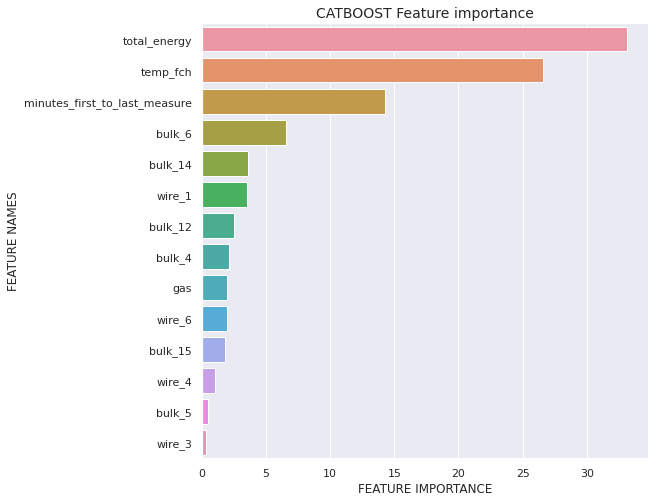

In [183]:
sns.set_theme(style='darkgrid')
plot_feature_importance(CBRModel_best.get_feature_importance(), features.columns,'CATBOOST')

Признаки по их важности можно разделить на `4` блока:

**1. Приоритетные**
- полная переданная энергия `total_energy`
- первая измеренная температура `temp_fch`
- время между первым и последним результативными измерениями температуры `minutes_first_to_last_measure`

**2. Важные**
- сыпучий материал `bulk_6`
- сыпучий материал `bulk_14`
- проволочный материал `wire_1`


**3. Несущественные**
- сыпучий материал `bulk_12`
- проволочный материал `wire_6`
- инертный газ `gas`
- сыпучий материал `bulk_4`
- сыпучий материал `bulk_15`

**4. Малозначимые**
- сыпучий материал `bulk_5`
- проволочные материалы `wire_3`, `wire_4`


Итого: **важных** и **приоритетных** признаков всего `6`.

Посмотрим на зависимость наиболее важного признака `total_energy` и целевого признака `temp_trgt`

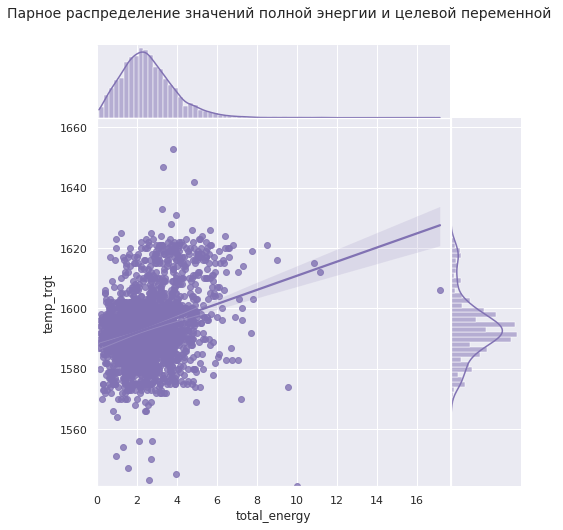

In [184]:
sns.jointplot(x=df['total_energy'],
              y=df['temp_trgt'],
              height=7,
              ratio=5,
              space=0.01,
              xlim=[0, df['total_energy'].max() +0.5],
              ylim=[df['temp_trgt'].min(), df['temp_trgt'].max() +10],
              kind='reg',
              color='m')
plt.suptitle('Парное распределение значений полной энергии и целевой переменной ',
             y = 1.05, fontsize = 14)
plt.show()

В матрице кореляции в разделе `3.6.6` мы видели, что корреляция между `total_energy` и `temp_trgt` составляет `0.3`. Из диаграммы выше тренд прямо-пропорциональной зависимости.

### Вывод

Из `14` признаков наиболее существенно влияют на значение целевой переменной `6`.

Приоритетные признаки:
- полная переданная энергия `total_energy`
- первая измеренная температура `temp_fch`
- время между первым и последним результативными измерениями температуры `minutes_first_to_last_measure`

Важные признаки:
- сыпучий материал `bulk_6`
- сыпучий материал `bulk_14`
- проволочный материал `wire_1`

## Общий вывод

В ходе работы над проектом было выполнено.

1. Проведено первичное исследование таблиц БД, определен состав таблиц, полнота данных, пересечение таблиц по общему ключу;


2. Даны ответы на обязательные вопросы;


3. Произведена выгрузка из БД;


4. Исследованы данные по времени определены номера партий `key` для которых есть переход через ответку `00:00:00`;


5. Исследованы данные из таблиц:
- данные замеров температуры `temp`
- данные нагрева `arc`
- данные по сыпучим материалам `bulk`
- данные по проволочным материалам `wire`
- данные по продувке газом `gas`


Для всех данных изменен формата отметок времени с `time` на `datetime`, для каждой партии `key` выбраны события, которые произошли между временем первого измерения и временем последнего измерения температуры, при этом партии, для которых зафиксировано только одно измернеие температуры - исключены. Данные проверены на выбросы, выбросы исключены.

6. Составлена единая таблица `df` со всеми данными для модели, выделен целевой признак `temp_trgt` как последний замер в серии замеров, проведена проверка на мультиколлинеарность и проверка на аномалии. Признаки с высокой взаимной корреляцией отфильтрованы, аномалии в данных - удалены. Итоговая таблица имеет размерность `2303, 15`. Данные разделены на тренировочные, валиадционные и тестовые в соотношениия `70 : 15 : 15` с размерностями `1611, 346, 346`; 


7. В соответствии с условиями задачи выбраны модели:
- `RandomForestRegressor`
- `CatBoostregressor`
- `FC нейронная сеть`

Для каждой модели подобраны оптимальные гиперпараметры.

8. Лучшая модель по значению **`MAE`** на валидации проверена на тестовых данных. Лучшей моделью по метрике **`MAE`** на валидации стал `CatBoostRegressor`. 


9. Проведен анализ важности признаков, выявлены приоритетные и важные признаки. Для признка **полная переданная энергия** `total_energy` проведен анализ взаимосвязи с целевой переменной `temp_trgt`


**РЕКОМЕНДАЦИИ ДЛЯ ЗАКАЗЧИКА**
1. Выяснить причину из-за которой значения температуры в таблицу `steel.data_temp` не фиксируются (отметка времени `MesaureTime` есть, а данных по температуре `Temperature` - нет)
2. Для таблиц `steel.data_temp`, `steel.data_arc_time`, `steel.data_bulk_time` и `steel.data_wire_time` крайне желательно фиксировать отметку времени в формате `datetime` (сейчас формат `time`)